# Forecasting Air Pollutants

In this notebook, we will forecast the concentration of various air pollutants. Specifically, we will forecast the pollutant concentration in the next hour using all available data up to the hour before the forecast.

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The dataset was collected between January 2004 and March 2005.

It consists of hourly measurements of the different air pollutants: NO2, NOX, CO, C6H6, O3 and NMHC. The measurements are accompanied by local temperature and humidity values, also recorded hourly.

In the data collection experiments, scientists were testing new pollutant sensors. The values from the new sensors are stored in the variables called "_sensors". 

For comparison, data for the pollutants was also gathered from fixed stations that regularly measure the concentration of these gases. Those values are stored in the variables called "_true".

## Challenge

This dataset is particularly challenging because it does not have equidistant timestamps. The timestamps should be equidistant because the scientists aimed to have a pollutant record for each hour. But in practice, we have entire days of recordings missing, probably due to data collection failure.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from feature_engine.creation import CyclicalTransformer
from feature_engine.selection import DropFeatures

# Video 1: Data analysis

## Load data

In [2]:
# If you followed the instructions, the data should be
# located here:

filename = '../datasets/AirQualityUCI_ready.csv'

# Load data.
data = pd.read_csv(filename)

print(data.shape)

data.head()

(9357, 14)


,Date_Time,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
0,2004-10-03 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-10-03 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-10-03 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-10-03 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-10-03 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


The first column is the timestamp. T, RH and AH are temperature and 2 measures of humidity. The rest of the columns are the measurements of the different pollutants by the sensors or the traditional stations.

In [3]:
# Cast date variable in datetime format.

data['Date_Time'] = pd.to_datetime(data['Date_Time'])

data.head()

,Date_Time,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
0,2004-10-03 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-10-03 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-10-03 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-10-03 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-10-03 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
# Quick check: data span.

data['Date_Time'].agg(['min', 'max'])

min   2004-01-04 00:00:00
max   2005-12-03 23:00:00
Name: Date_Time, dtype: datetime64[ns]

In [5]:
# Quick check: missing data.

data.isnull().sum()

Date_Time      0
CO_true        0
CO_sensor      0
NMHC_true      0
C6H6_true      0
NMHC_sensor    0
NOX_true       0
NOX_sensor     0
NO2_true       0
NO2_sensor     0
O3_sensor      0
T              0
RH             0
AH             0
dtype: int64

There are no NaN values.

## Set index as datetime

In [6]:
# Set the index to the timestamp.

data.index = data['Date_Time']

In [7]:
# Sanity: sort index.

data.sort_index(inplace=True)

## Quick analysis - plot time series

In [8]:
# Let's capture the variables, except the datetime, in a list.

variables = data.columns[1:]

variables

Index(['CO_true', 'CO_sensor', 'NMHC_true', 'C6H6_true', 'NMHC_sensor',
       'NOX_true', 'NOX_sensor', 'NO2_true', 'NO2_sensor', 'O3_sensor', 'T',
       'RH', 'AH'],
      dtype='object')

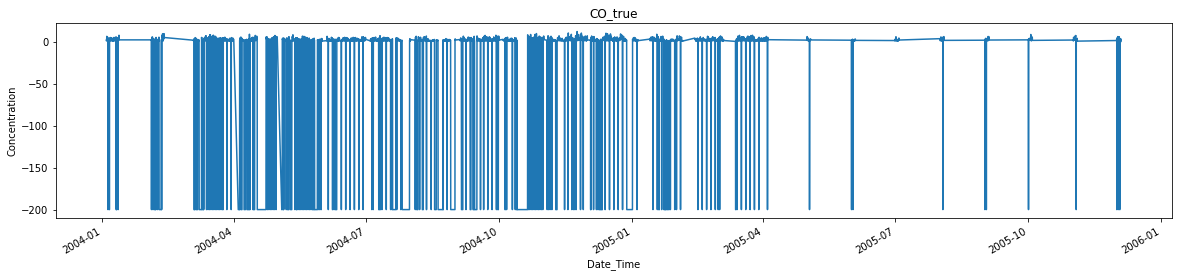

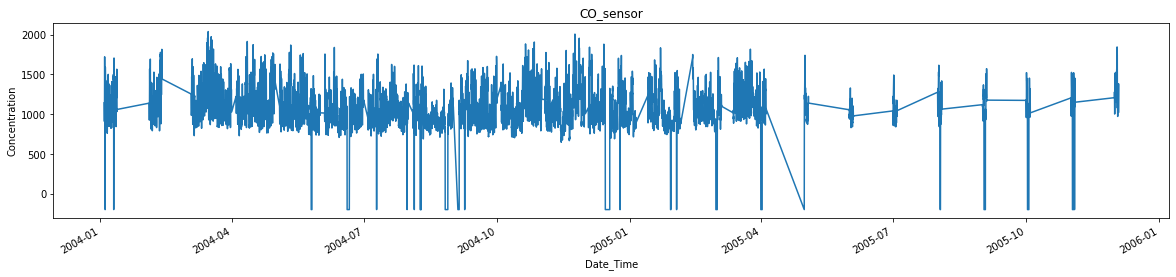

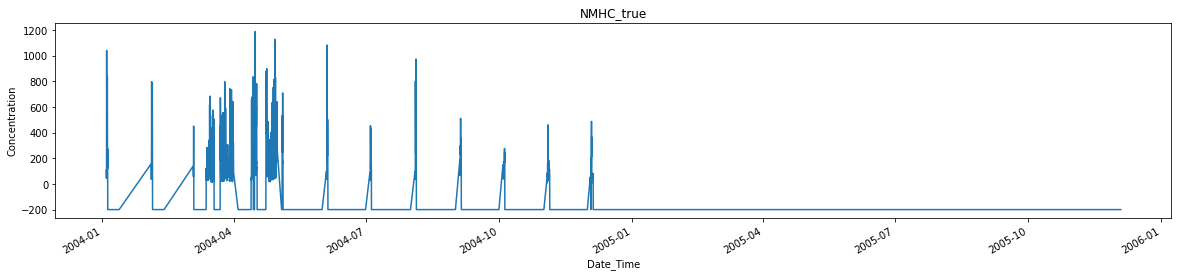

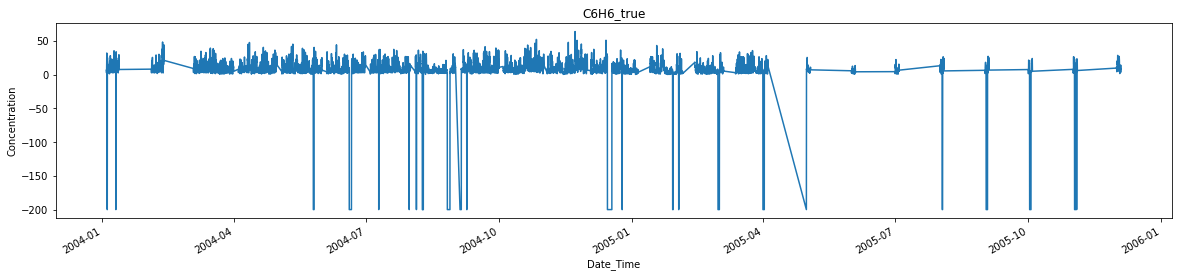

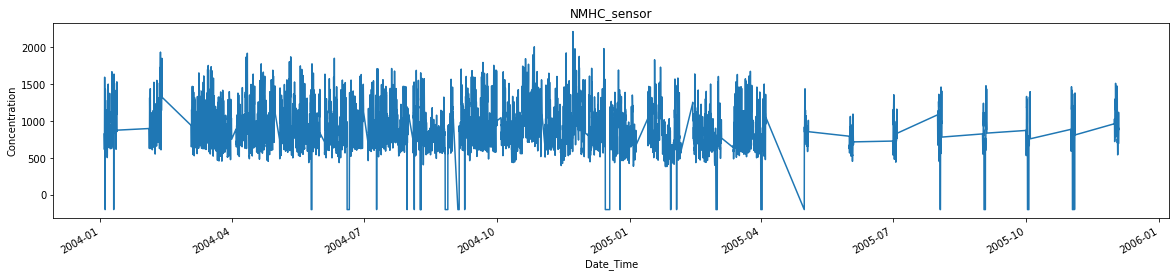

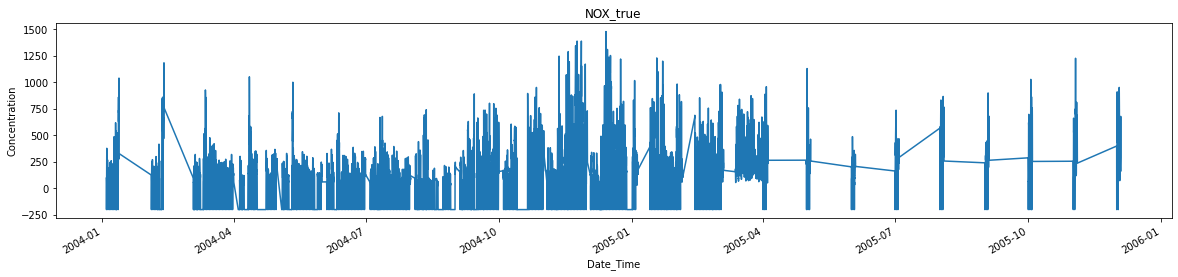

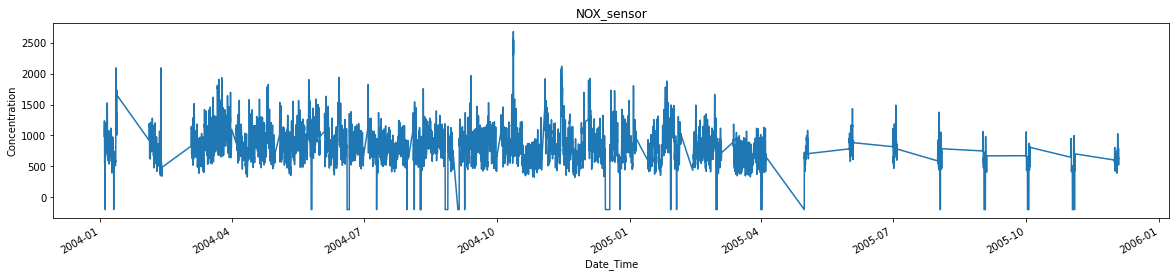

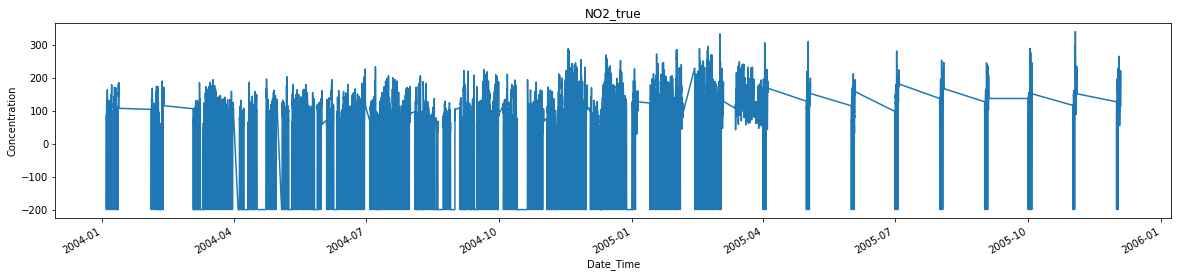

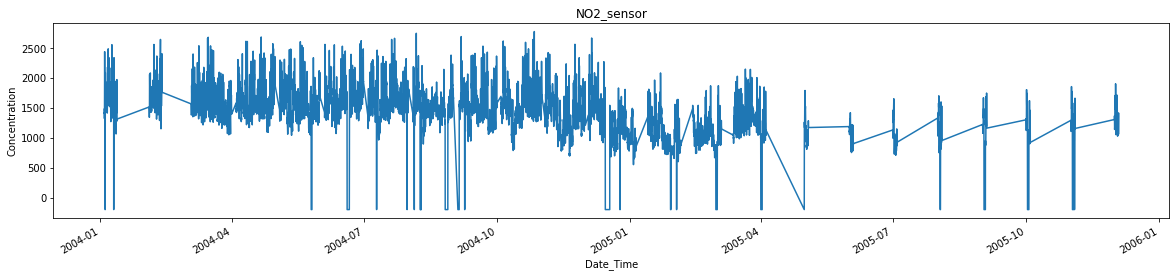

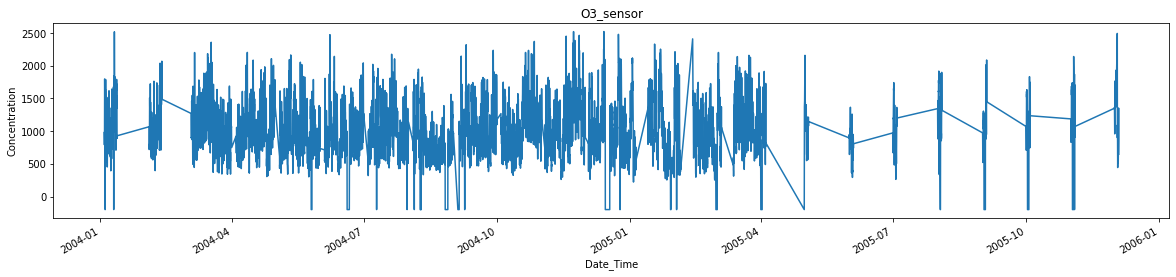

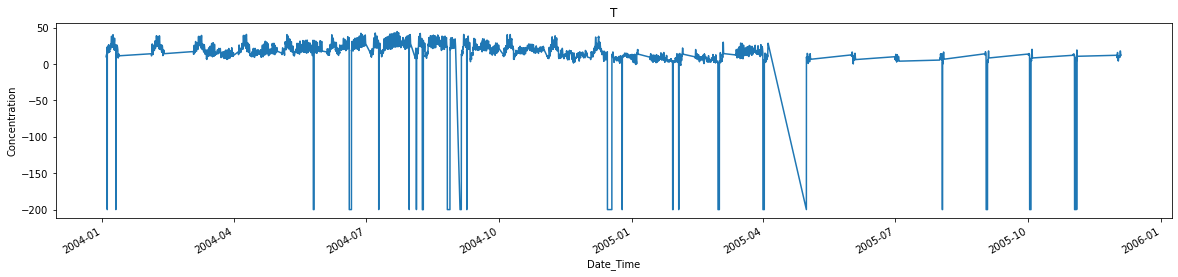

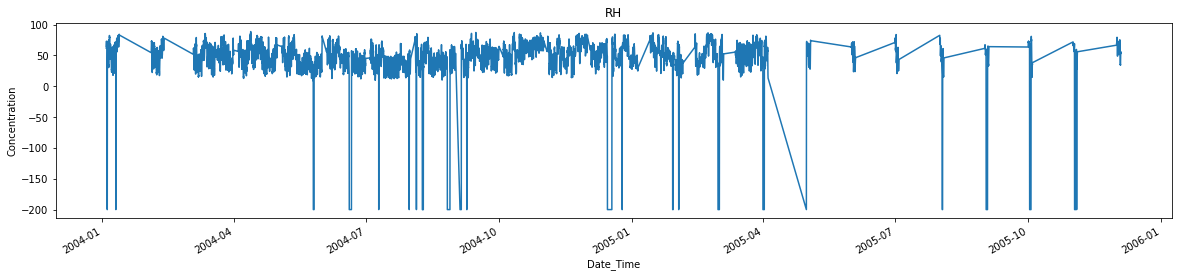

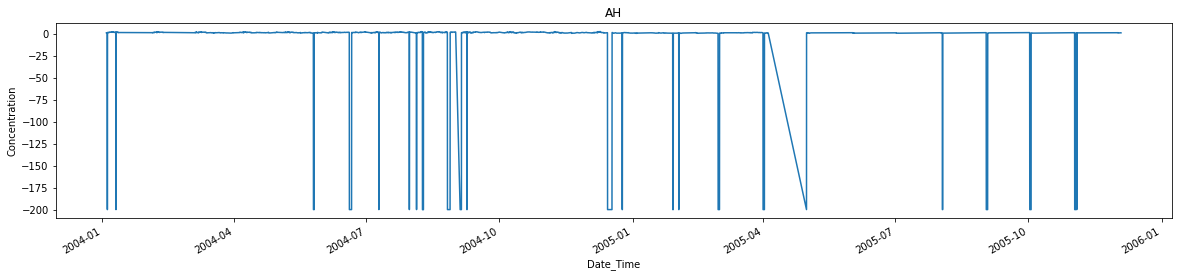

In [9]:
# Plot the time series.

for var in variables:
    
    data[var].plot(figsize=(20,4))
    plt.title(var)
    plt.ylabel('Concentration')
    plt.show()

Looking at the plots, we can argue the following:


- Data before March 2004 or after April 2005 seems to be more sparse (more data is missing).

- There are records missing: pandas plot interpolates linearly between available values.

- Some values are negative, most likely measurement errors, as concentrations should not be negative.

- The sensors seem to be more reliable than the fixed stations, as they provide more and better quality data.

For the demo, we will:

- Reduce the data to the span between March 2004 and April 2005 (best quality).

- Work only with the sensor values.

- Remove negative values, that is, remove outliers.


## Highlight missing timestamps

To highlight the missing timestamps, I will first introduce them in the dataset. This will introduce NaN into the variables. Then I will fill in the NAN, carrying the last value forward. And finally, I will plot the imputed data to highlight the missing timestamps.

In [10]:
# Introduce the missing timestamps.
# Note that we capture this in a different variable.
data_ = data.set_index(data['Date_Time']).asfreq('1H')

# Compare the shapes.
data_.shape, data.shape

((16800, 14), (9357, 14))

As you can see, the shape of the new dataset is much bigger than the original one, because it now has all the timestamps that were originally missing. 

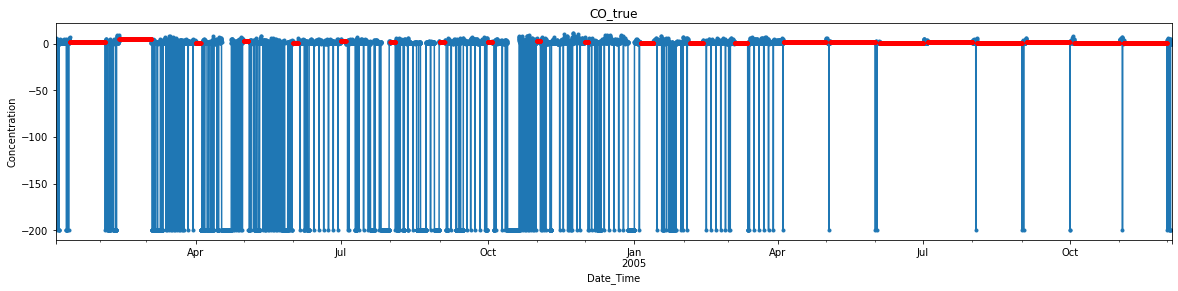

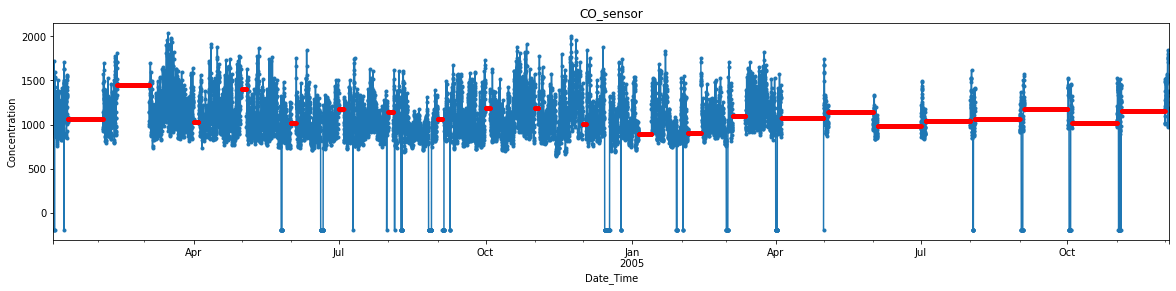

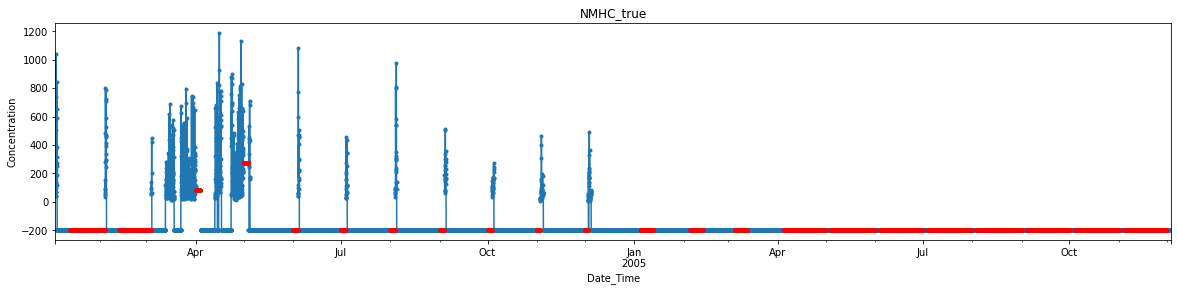

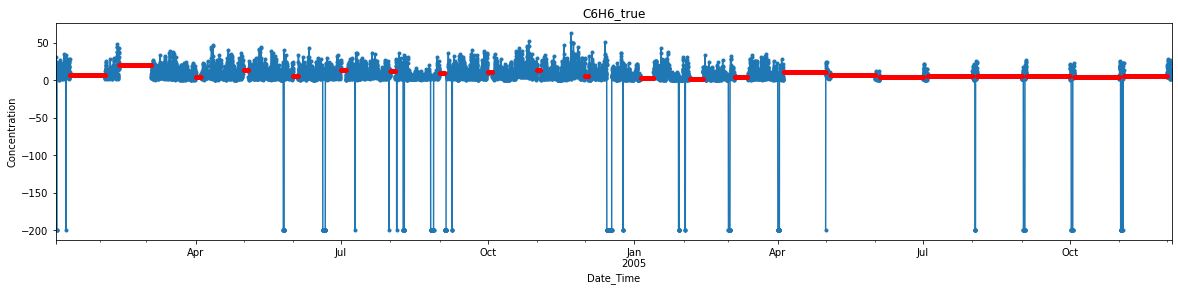

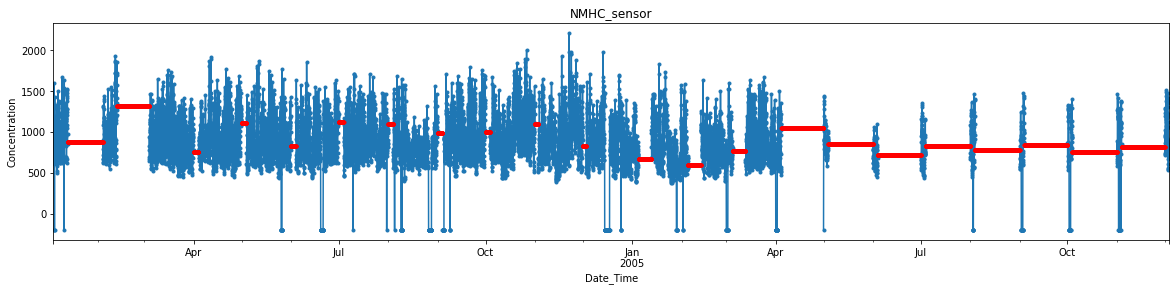

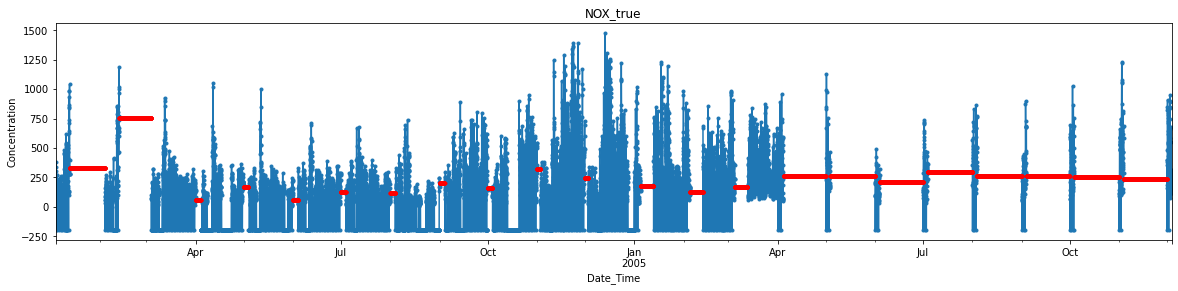

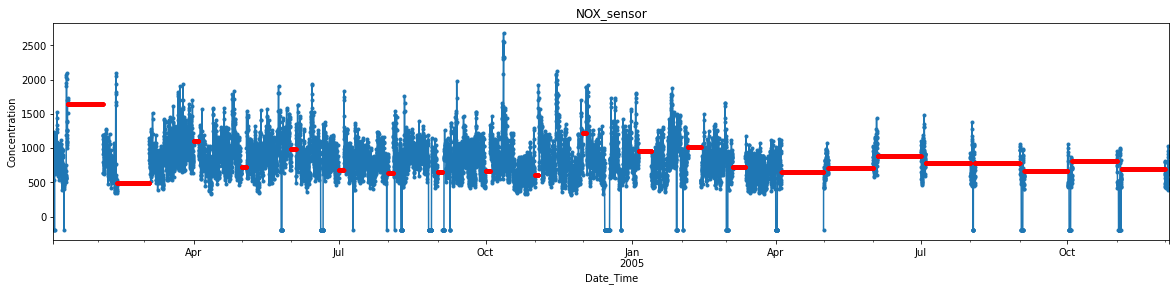

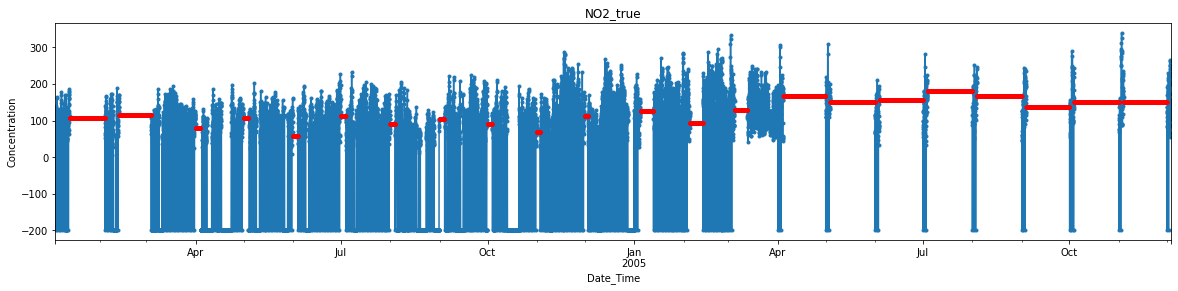

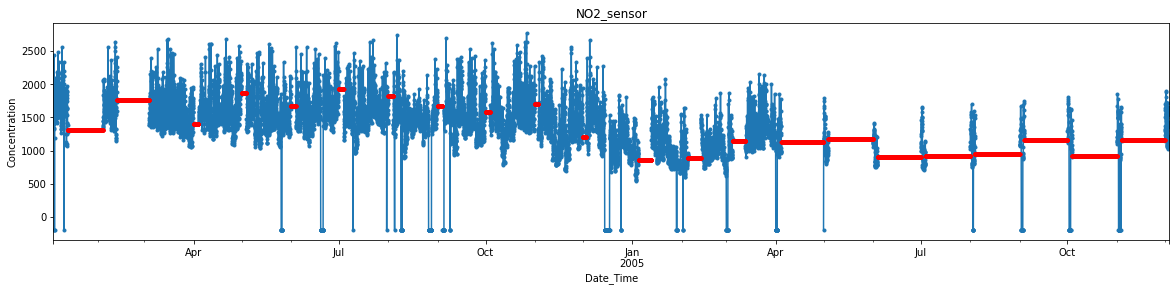

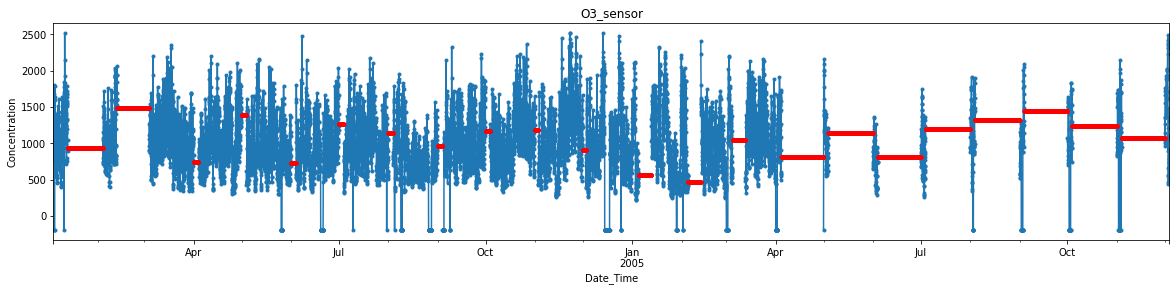

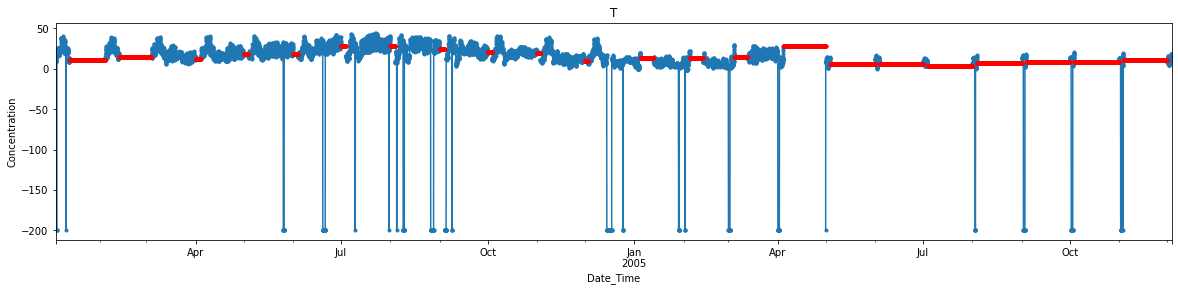

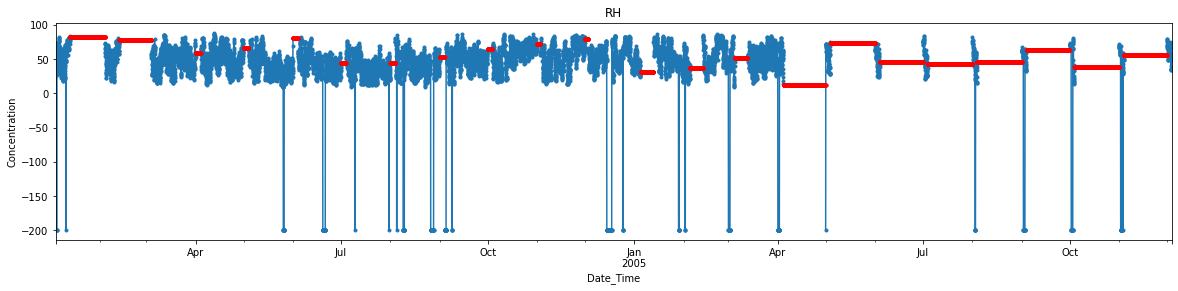

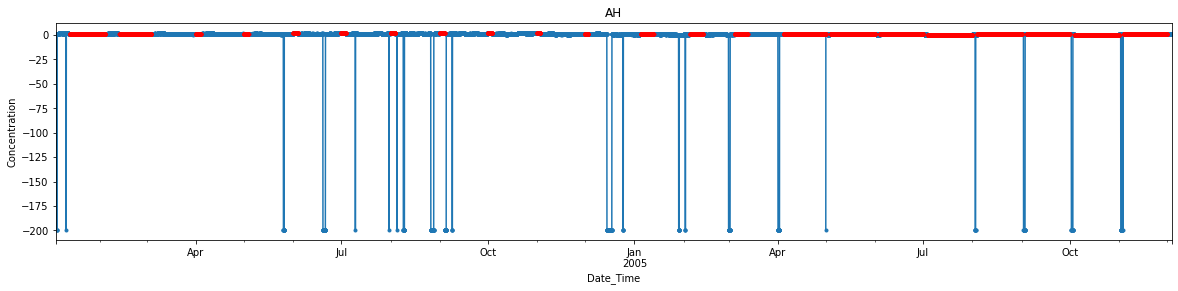

In [11]:
# Apply the forward fill method.
data_imputed = data_.fillna(method='ffill')

# Plot the imputed time series.
for var in variables:
    ax = data_[var].plot(linestyle='-', marker='.', figsize=[20, 4])
    data_imputed[data_.isnull()][var].plot(
        ax=ax, legend=None, marker='.', color='r')
    plt.title(var)
    plt.ylabel('Concentration')
    plt.show()

## Reduce data span

I will narrow down the dataset to those portions with fewer timestamps missing.

In [12]:
# According to plots, narrow down data 
# to the interval with the most data available.

data = data[(
    data['Date_Time'] >= '2004-04-01') &
    (data['Date_Time'] <= '2005-04-30')
]

# Quick check: data span.

data['Date_Time'].agg(['min', 'max'])

min   2004-04-04 00:00:00
max   2005-04-04 14:00:00
Name: Date_Time, dtype: datetime64[ns]

We see that the minimum and maximum values do not coincide with those we set, because there are timestamps missing. In other words, we do not have measurements for every single day or every single hour.

## Reduce number of variables

In [13]:
# Remove measurements from fixed stations.
# We'll only be using sensor data.

drop_vars  = [var for var in data.columns if '_true' in var]

# Remove relative humidity.
drop_vars.append('AH')

# Remove variables.
data.drop(labels=drop_vars, axis=1, inplace=True)

data.shape

(7677, 8)

In [14]:
# Remaining variables:

data.columns

Index(['Date_Time', 'CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor',
       'O3_sensor', 'T', 'RH'],
      dtype='object')

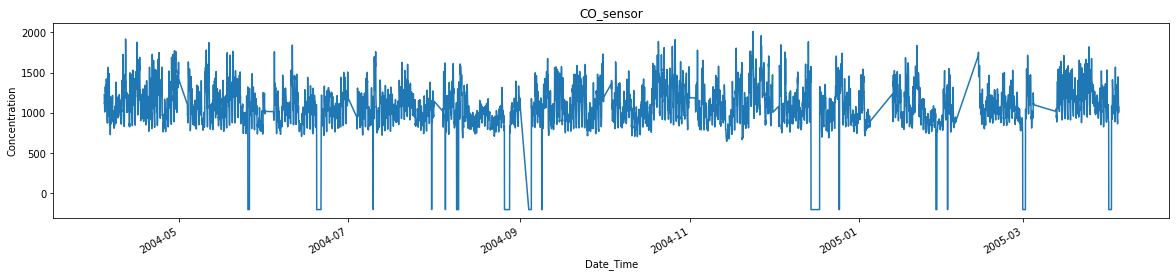

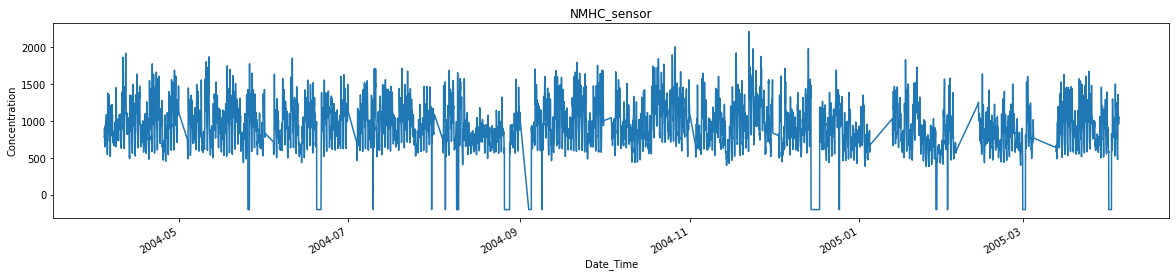

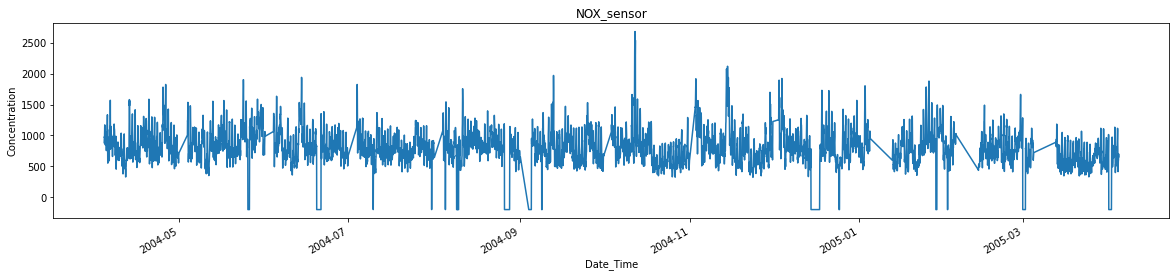

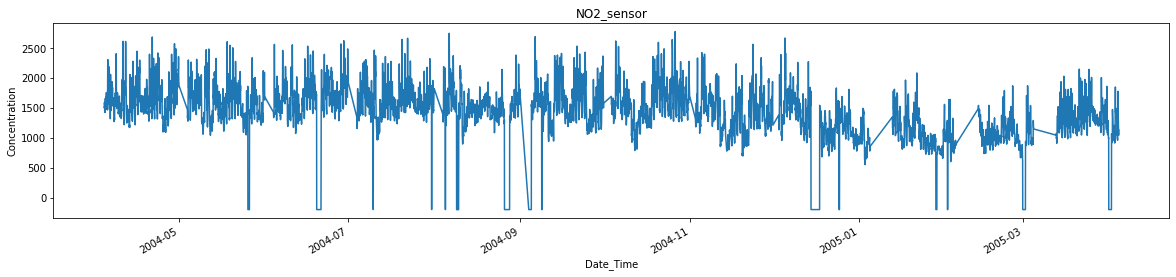

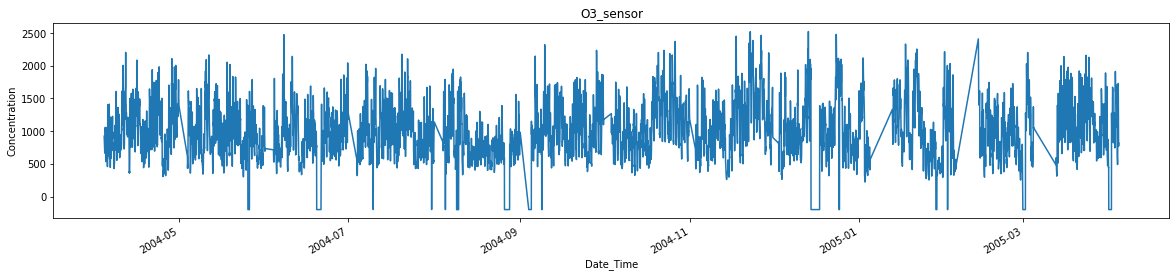

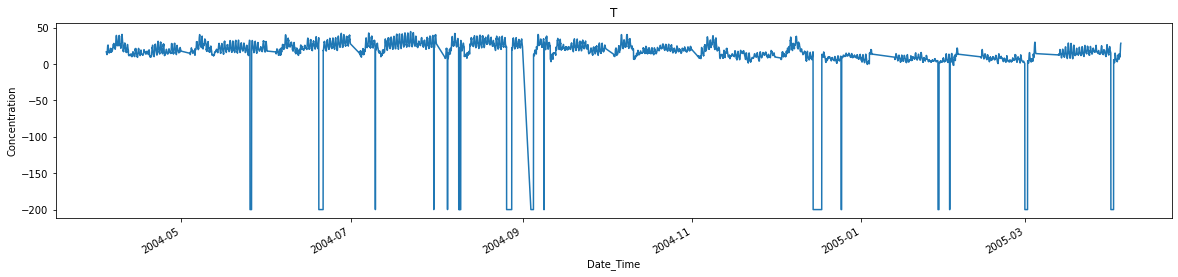

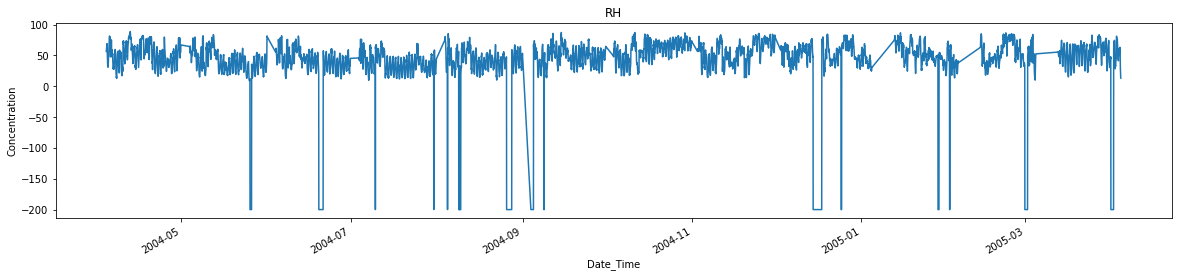

In [15]:
# Let's capture the variables, 
# except the datetime, in a list.

variables = list(data.columns[1:])


# Plot the time series again.
for var in variables:
    
    data[var].plot(figsize=(20,4))
    plt.title(var)
    plt.ylabel('Concentration')
    plt.show()

The data looks much better. 

We have entire days of records missing (note big gaps). These gaps occur across all sensors. This happens because all sensors are located within 1 measurement unit. So if for some reason the unit does not work, we will miss records for all sensors. 

I don't think that filling in entire days of missing data is the way forward, so we will not use those days to train the forecasting model.

Having said this, I would like to show you which time stamps are missing.

## Missing timestamps

In [16]:
# We determine the difference in time between
# one row and its previous row.

data['diff'] = data['Date_Time'].diff()

# We expect the difference to be 1 hr if all records
# are present. If we miss some hourly records, the difference
# will be bigger:

data[data['diff'] > datetime.timedelta(hours=1)].head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,diff
Date_Time,,,,,,,,,
2004-05-04,2004-05-04,1102.0,750.0,1007.0,1470.0,613.0,14.7,64.4,3 days 01:00:00
2004-06-04,2004-06-04,1015.0,718.0,1065.0,1428.0,714.0,16.6,55.4,3 days 01:00:00
2004-07-04,2004-07-04,948.0,710.0,1127.0,1352.0,575.0,15.7,45.9,3 days 01:00:00
2004-08-04,2004-08-04,1020.0,752.0,1074.0,1398.0,839.0,9.3,75.0,3 days 01:00:00
2004-09-04,2004-09-04,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,3 days 01:00:00


In the above view of the data, we see some timestamps for which the previous hourly records are missing. That is why the difference is greater than 1 hour. In fact, in the data shown, 3 entire days of recordings are missing.

Let's have a closer look at one of those timestamps as an example:

In [17]:
timestamp_ = '2004-05-05'

data[data['Date_Time']<= timestamp_].tail(30)

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,diff
Date_Time,,,,,,,,,
2004-04-30 19:00:00,2004-04-30 19:00:00,1626.0,1476.0,555.0,2356.0,1786.0,19.8,58.6,0 days 01:00:00
2004-04-30 20:00:00,2004-04-30 20:00:00,1449.0,1282.0,625.0,2100.0,1569.0,19.1,61.1,0 days 01:00:00
2004-04-30 21:00:00,2004-04-30 21:00:00,1363.0,1152.0,684.0,1951.0,1495.0,18.2,65.4,0 days 01:00:00
2004-04-30 22:00:00,2004-04-30 22:00:00,1371.0,1136.0,689.0,1927.0,1471.0,18.1,66.1,0 days 01:00:00
2004-04-30 23:00:00,2004-04-30 23:00:00,1406.0,1107.0,718.0,1872.0,1384.0,17.7,66.9,0 days 01:00:00
2004-05-04 00:00:00,2004-05-04 00:00:00,1102.0,750.0,1007.0,1470.0,613.0,14.7,64.4,3 days 01:00:00
2004-05-04 01:00:00,2004-05-04 01:00:00,969.0,611.0,1239.0,1330.0,430.0,14.8,63.3,0 days 01:00:00
2004-05-04 02:00:00,2004-05-04 02:00:00,983.0,600.0,1233.0,1375.0,485.0,15.0,61.5,0 days 01:00:00
2004-05-04 03:00:00,2004-05-04 03:00:00,876.0,505.0,1456.0,1294.0,467.0,15.5,56.9,0 days 01:00:00


If you try and search in the data for the timestamp in question, you'll see that the previous hourly records are missing. Shame!

In [18]:
# I'll drop the diff variable now.

data.drop(labels=['diff'], axis=1, inplace=True)

## Data Analysis: Seasonality

Air pollutants change with car traffic. At rush hour, we have more pollutants. During the night hours, we have fewer pollutants.

Let's see if what I am saying is true.

In [19]:
# Capture "time" in a new variable.

data['Time'] = data['Date_Time'].dt.time

data['Time'].head()

Date_Time
2004-04-04 00:00:00    00:00:00
2004-04-04 01:00:00    01:00:00
2004-04-04 02:00:00    02:00:00
2004-04-04 03:00:00    03:00:00
2004-04-04 04:00:00    04:00:00
Name: Time, dtype: object

Text(0, 0.5, 'Concentration')

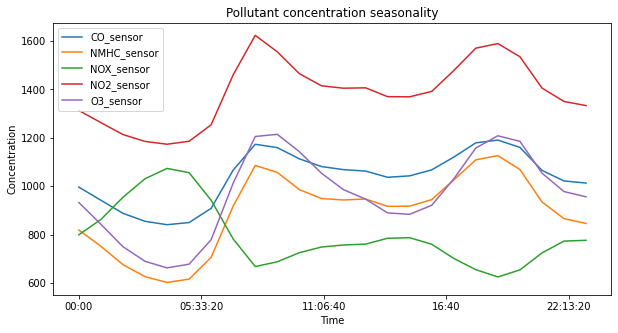

In [20]:
# Plot the average pollutant concentration per hour.

data.groupby('Time')[variables[:-2]].mean().plot(figsize=(10,5))
plt.title('Pollutant concentration seasonality')
plt.ylabel('Concentration')

Bingo! More pollutants are detected around 8–9 a.m. and again at 18–19 hs.

We also see that the concentration of the pollutants is correlated. So we could use the values of one pollutant to infer those of the others.

NOX cycle is different, with a peak at night.

In [21]:
# Drop the time variable from the data.

data.drop(labels=['Time'], axis=1, inplace=True)

# Video 2: Feature engineering

## Outliers

Now, we are going to go ahead and remove those negative values from our dataset.

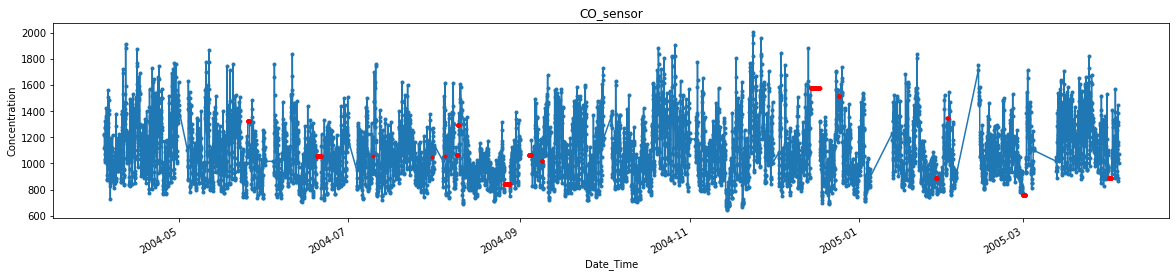

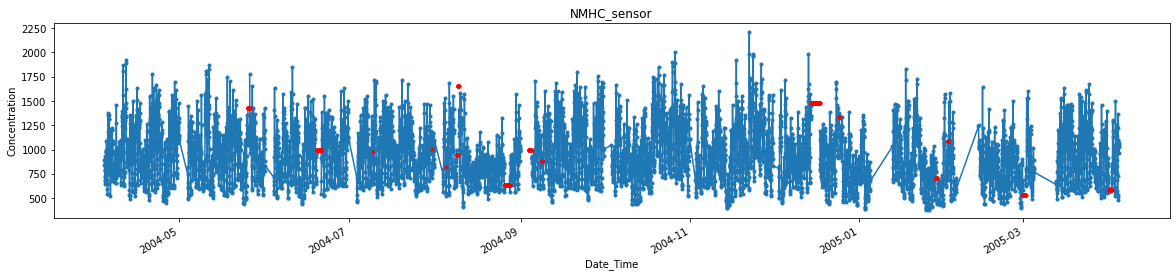

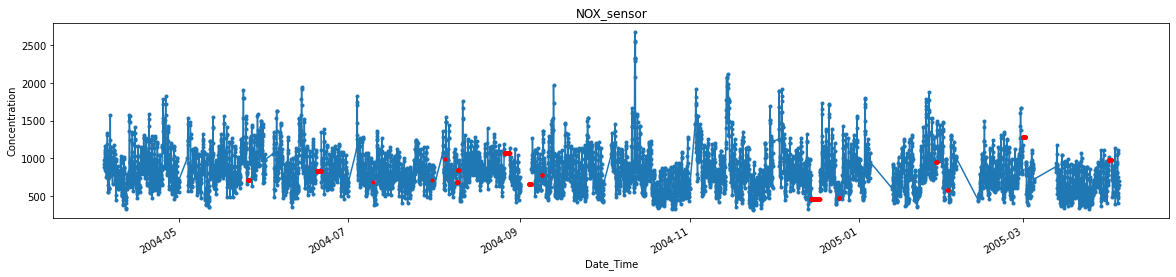

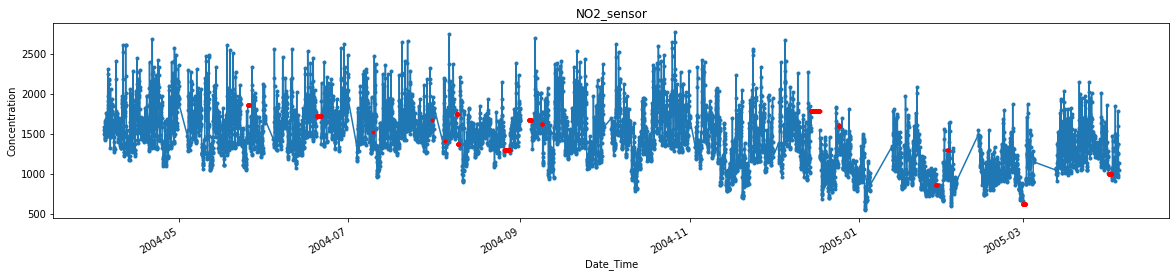

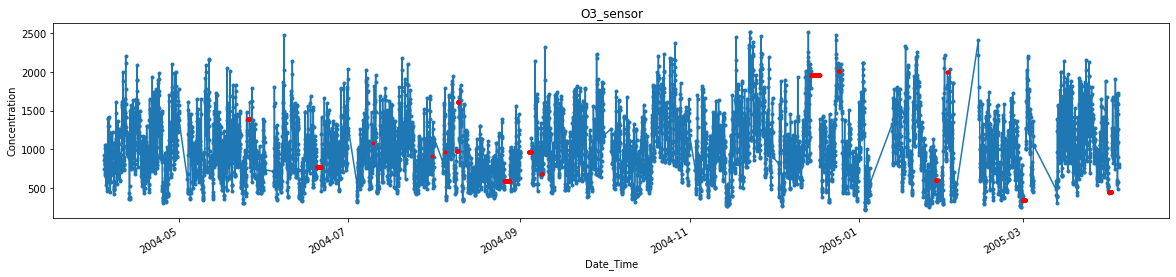

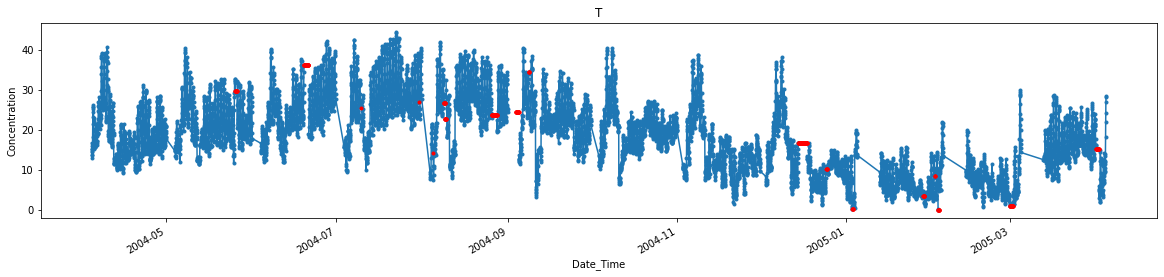

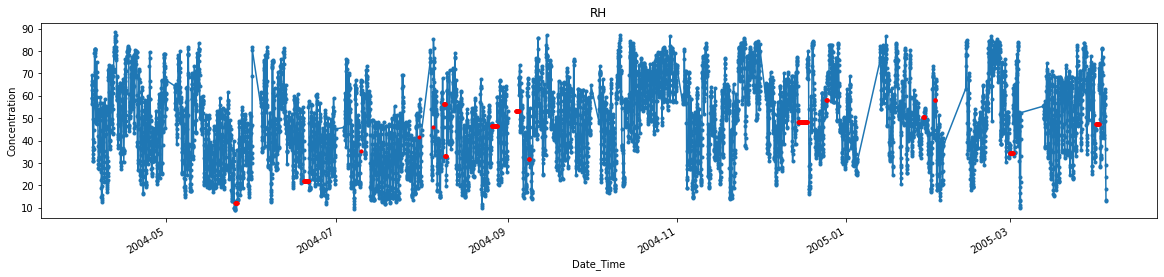

In [22]:
for var in variables:
    
    # If the value is negative, replace it by nan.
    data[var] = np.where(data[var]<0, np.nan, data[var])
    
    # Apply the forward fill method to 
    # highlight the data that was removed
    data_imputed = data.fillna(method='ffill')

    # Plot the time series
    ax = data[var].plot(linestyle='-', marker='.', figsize=[20, 4])
    data_imputed[data.isnull()][var].plot(
        ax=ax, legend=None, marker='.', color='r')
    plt.title(var)
    plt.ylabel('Concentration')
    plt.show()

In [23]:
# Now we have missing data.

data.isnull().sum()

Date_Time        0
CO_sensor      284
NMHC_sensor    284
NOX_sensor     284
NO2_sensor     284
O3_sensor      284
T              297
RH             284
dtype: int64

In [24]:
# Because there are entire days of records missing, 
# I believe it is best to not impute this data and 
# simply remove it from the data.

data[data['CO_sensor'].isnull()]

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
Date_Time,,,,,,,,
2004-05-25 19:00:00,2004-05-25 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 20:00:00,2004-05-25 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 21:00:00,2004-05-25 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 22:00:00,2004-05-25 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-25 23:00:00,2004-05-25 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2005-04-01 19:00:00,2005-04-01 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01 20:00:00,2005-04-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01 21:00:00,2005-04-01 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Imputation

We will just remove the observations with missing data.

In [25]:
data.dropna(inplace=True)

data.isnull().sum()

Date_Time      0
CO_sensor      0
NMHC_sensor    0
NOX_sensor     0
NO2_sensor     0
O3_sensor      0
T              0
RH             0
dtype: int64

In [26]:
data.shape

(7380, 8)

## Forecasting

Now, we are ready to start creating some features for forecasting. 

We will begin with a simple scenario: we just want to forecast the pollutant concentration in the next hour.


<img src='../forecasting_framework.png' width="600" height="600">


We want to predict the pollutant concentration at time t, and we know the concentration up to t-1. So for each t, we can use data up to t-1. 

Except for the timestamp, because we know at which time we want to predict pollutants.

Let's go and create some features.

In [27]:
data.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH
Date_Time,,,,,,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,892.0,884.0,1580.0,923.0,16.7,56.5
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,843.0,929.0,1551.0,862.0,15.9,59.2
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,782.0,980.0,1500.0,752.0,15.2,62.4
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,793.0,965.0,1521.0,791.0,14.7,65.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,682.0,1090.0,1448.0,697.0,14.3,65.3


In [28]:
# Our original time series

variables

['CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

In [29]:
# The variables we want to forecast.

pollutants = variables[:-2]

pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

## Extract time related features

These are features that capture information from the timestamp.

In [30]:
# Extract date and time features.

data['Month'] = data['Date_Time'].dt.month
data['Week'] = data['Date_Time'].dt.isocalendar().week
data['Day'] = data['Date_Time'].dt.day
data['Day_of_week'] = data['Date_Time'].dt.day_of_week
data['Hour'] = data['Date_Time'].dt.hour

# find out if it is a weekend.
data['is_weekend'] = np.where(data['Day_of_week'].isin(['5,6']),1,0)

# Captrue date and time variable names.
time_vars = ['Month', 'Week', 'Day', 'Day_of_week', 'Hour']
                      
# Show new variables
data[['Date_Time']+time_vars].head()

,Date_Time,Month,Week,Day,Day_of_week,Hour
Date_Time,,,,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,4,14,4,6,0
2004-04-04 01:00:00,2004-04-04 01:00:00,4,14,4,6,1
2004-04-04 02:00:00,2004-04-04 02:00:00,4,14,4,6,2
2004-04-04 03:00:00,2004-04-04 03:00:00,4,14,4,6,3
2004-04-04 04:00:00,2004-04-04 04:00:00,4,14,4,6,4


## Lag Features

Those lag features are past values of the variable that we use to predict future values.

<img src='../lag_features.png' width="600" height="600">


I will use the following proxies to predict the next hour's pollutant concentration:

- The pollutant concentration for the previous hour (t-1).

- The pollutant concentration for the same hour on the previous day (t-24).

The reasoning behind this is that pollutant concentrations do not change quickly and, as previously demonstrated, have a 24-hour seasonality.

**We need to be careful because we do not have values for all timestamps. To be safe, we must shift the data using pandas frequency.**

In [31]:
# Here, I show how to move the variables forward by 1 hr, 
# so that the pollutant concentration from the previous 
# hour (t-1) is aligned with the current hour (t), 
# which is the time stamp we want to make predictions about.

# Shift the data forward 1 Hr.
tmp = data[variables].shift(freq='1H')

# Name the new variables.
tmp.columns = [v + '_lag_1' for v in variables]


# Add the variables to the original data.
print('data size before')
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how='left')

print('data size after')
print(data.shape)

data[['Date_Time', 'CO_sensor', 'CO_sensor_lag_1']].head()

data size before
(7380, 14)
data size after
(7380, 21)


,Date_Time,CO_sensor,CO_sensor_lag_1
Date_Time,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,1224.0
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,1215.0
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,1115.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,1124.0


We see for example that 1224 is now moved forward to the next t.

In [32]:
# In this procedure, we introduced missing 
# data whenever there was no data available in 
# the previous hour.

data.isnull().sum()

Date_Time             0
CO_sensor             0
NMHC_sensor           0
NOX_sensor            0
NO2_sensor            0
O3_sensor             0
T                     0
RH                    0
Month                 0
Week                  0
Day                   0
Day_of_week           0
Hour                  0
is_weekend            0
CO_sensor_lag_1      29
NMHC_sensor_lag_1    29
NOX_sensor_lag_1     29
NO2_sensor_lag_1     29
O3_sensor_lag_1      29
T_lag_1              29
RH_lag_1             29
dtype: int64

Our timestamps are not equidistant. This means that not every row has information from the previous hour.

But, as we specified the frequency in pandas shift(), for those records where we do not have a value in the previous hr, we will see NAN. Look below:

In [33]:
# We created this variable previously.

timestamp_

'2004-05-05'

In [34]:
data[data['Date_Time'] <= timestamp_][[
    'Date_Time', 'CO_sensor', 'CO_sensor_lag_1']].tail(30)

,Date_Time,CO_sensor,CO_sensor_lag_1
Date_Time,,,
2004-04-30 19:00:00,2004-04-30 19:00:00,1626.0,1480.0
2004-04-30 20:00:00,2004-04-30 20:00:00,1449.0,1626.0
2004-04-30 21:00:00,2004-04-30 21:00:00,1363.0,1449.0
2004-04-30 22:00:00,2004-04-30 22:00:00,1371.0,1363.0
2004-04-30 23:00:00,2004-04-30 23:00:00,1406.0,1371.0
2004-05-04 00:00:00,2004-05-04 00:00:00,1102.0,NaN
2004-05-04 01:00:00,2004-05-04 01:00:00,969.0,1102.0
2004-05-04 02:00:00,2004-05-04 02:00:00,983.0,969.0
2004-05-04 03:00:00,2004-05-04 03:00:00,876.0,983.0


In [35]:
# Now we repeat the exercise, but this time 
# the values are moved forward 24 hours.

# Move forward 24 hrs.
tmp = data[variables].shift(freq='24H')


# Rename the variables.
tmp.columns = [v + '_lag_24' for v in variables]


# Add the features to the original data.
print('data size before')
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how='left')

print('data size after')
print(data.shape)

data[['Date_Time', 'CO_sensor', 'CO_sensor_lag_24']].head(25)

data size before
(7380, 21)
data size after
(7380, 28)


,Date_Time,CO_sensor,CO_sensor_lag_24
Date_Time,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,NaN
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,NaN
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,NaN
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,NaN
2004-04-04 05:00:00,2004-04-04 05:00:00,1010.0,NaN
2004-04-04 06:00:00,2004-04-04 06:00:00,1074.0,NaN
2004-04-04 07:00:00,2004-04-04 07:00:00,1034.0,NaN
2004-04-04 08:00:00,2004-04-04 08:00:00,1130.0,NaN


Note now that 1224, which is the value corresponding to April 4 at midnight, is not located on April 5th at midnight. We have NA for all previous values because there is no information about the features 24 hours before.

In [36]:
# In this procedure, we introduced missing 
# data whenever there was no data available in 
# the previous 24 hours.

data.isnull().sum()

Date_Time               0
CO_sensor               0
NMHC_sensor             0
NOX_sensor              0
NO2_sensor              0
O3_sensor               0
T                       0
RH                      0
Month                   0
Week                    0
Day                     0
Day_of_week             0
Hour                    0
is_weekend              0
CO_sensor_lag_1        29
NMHC_sensor_lag_1      29
NOX_sensor_lag_1       29
NO2_sensor_lag_1       29
O3_sensor_lag_1        29
T_lag_1                29
RH_lag_1               29
CO_sensor_lag_24      474
NMHC_sensor_lag_24    474
NOX_sensor_lag_24     474
NO2_sensor_lag_24     474
O3_sensor_lag_24      474
T_lag_24              474
RH_lag_24             474
dtype: int64

## Window features

Window features are mathematical computations of the features' values over a pre-defined time window, prior to the time we want to forecast.

<img src='../window_features.png' width="600" height="600">

For the demonstration, I will take the average of the previous 3 values of the TS to predict the current value. 

We first need to calculate the average of the 3 previous values, and then move that value forward.

In [37]:
# Use the mean of the 3 previous hours as input variables.

tmp = (data[variables]
       .rolling(window='3H').mean()  # Average the last 3 hr values.
       .shift(freq='1H')  # Move the average 1 step forward
       )

# Rename the columns
tmp.columns = [v + '_window' for v in variables]


# view of the result
tmp.head(10)

,CO_sensor_window,NMHC_sensor_window,NOX_sensor_window,NO2_sensor_window,O3_sensor_window,T_window,RH_window
Date_Time,,,,,,,
2004-04-04 01:00:00,1224.000000,892.000000,884.000000,1580.000000,923.000000,16.700000,56.500000
2004-04-04 02:00:00,1219.500000,867.500000,906.500000,1565.500000,892.500000,16.300000,57.850000
2004-04-04 03:00:00,1184.666667,839.000000,931.000000,1543.666667,845.666667,15.933333,59.366667
2004-04-04 04:00:00,1151.333333,806.000000,958.000000,1524.000000,801.666667,15.266667,62.200000
2004-04-04 05:00:00,1089.000000,752.333333,1011.666667,1489.666667,746.666667,14.733333,64.233333
2004-04-04 06:00:00,1054.000000,708.333333,1075.333333,1467.666667,717.333333,14.233333,65.600000
2004-04-04 07:00:00,1037.333333,687.666667,1093.666667,1456.666667,750.666667,13.633333,66.966667
2004-04-04 08:00:00,1039.333333,688.333333,1100.333333,1448.333333,789.333333,13.433333,66.800000
2004-04-04 09:00:00,1079.333333,711.666667,1064.333333,1457.333333,844.000000,13.966667,64.300000


In [38]:
# Join the variables to the original data.
print('data size before')
print(data.shape)

data = data.merge(tmp, left_index=True, right_index=True, how='left')

print('data size after')
print(data.shape)

data[['Date_Time', 'CO_sensor', 'CO_sensor_window']].head()

data size before
(7380, 28)
data size after
(7380, 35)


,Date_Time,CO_sensor,CO_sensor_window
Date_Time,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,1224.000000
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,1219.500000
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,1184.666667
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,1151.333333


Now we do some manual calculations to convince ourselves of the results.

In [39]:
(1215+1224)/2

1219.5

In [40]:
(1115+1215+1224)/3

1184.6666666666667

**Important:** Notice how the average of the previous three hours was advanced an hour to time t, the time we want to forecast.

## Feature combinations: total pollutants

We mentioned that we can also combine time series to create new features. So here we will add up all the pollutants' concentrations.

I'm not sure if it makes sense, but indulge me for the demo.

**Important:**

We only know the concentration of the pollutants up to 1 hour before the forecast time, so we should add the lagged features and not the original variables!

In [41]:
# Capture all lag 1 features.
lag_1 = [v for v in data.columns if 'lag_1' in v]

# Remove temperature and humidity.
lag_1 = lag_1[:-2]

lag_1

['CO_sensor_lag_1',
 'NMHC_sensor_lag_1',
 'NOX_sensor_lag_1',
 'NO2_sensor_lag_1',
 'O3_sensor_lag_1']

In [42]:
data['total_poll_lag_1'] = data[lag_1].sum(axis=1)

data[lag_1 + ['total_poll_lag_1']].head()

,CO_sensor_lag_1,NMHC_sensor_lag_1,NOX_sensor_lag_1,NO2_sensor_lag_1,O3_sensor_lag_1,total_poll_lag_1
Date_Time,,,,,,
2004-04-04 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0
2004-04-04 01:00:00,1224.0,892.0,884.0,1580.0,923.0,5503.0
2004-04-04 02:00:00,1215.0,843.0,929.0,1551.0,862.0,5400.0
2004-04-04 03:00:00,1115.0,782.0,980.0,1500.0,752.0,5129.0
2004-04-04 04:00:00,1124.0,793.0,965.0,1521.0,791.0,5194.0


In [43]:
# Now we repeat the exercise using the features with 24 Hr lag.

# Capture lagged features.
lag_24 = [v for v in data.columns if 'lag_24' in v]

# Remove temperature and humidity.
lag_24 = lag_24[:-2]

data['total_poll_lag_24'] = data[lag_24].sum(axis=1)

data[lag_24 + ['total_poll_lag_24']].tail()

,CO_sensor_lag_24,NMHC_sensor_lag_24,NOX_sensor_lag_24,NO2_sensor_lag_24,O3_sensor_lag_24,total_poll_lag_24
Date_Time,,,,,,
2005-04-04 10:00:00,1334.0,1174.0,524.0,1432.0,1643.0,6107.0
2005-04-04 11:00:00,1280.0,1165.0,533.0,1435.0,1605.0,6018.0
2005-04-04 12:00:00,1330.0,1145.0,537.0,1399.0,1668.0,6079.0
2005-04-04 13:00:00,1349.0,1193.0,507.0,1493.0,1710.0,6252.0
2005-04-04 14:00:00,1349.0,1167.0,515.0,1443.0,1632.0,6106.0


## Periodic Features

Some features are periodic. For example, hours, months, and days.

We can encode those periodic features using a sine and cosine transformation with the feature's period. This will cause the values of the features that are far apart to come closer. For example, December (12) is closer to January (1) than June (6). This relationship is not captured by the numerical representation of these features. But we could change it if we transformed these variables with sine and cosine.

We will discuss this technique later on in the course. For now, let's create these features automatically with the open source library Feature-engine.

[CyclicalTransformer](https://feature-engine.readthedocs.io/en/latest/creation/CyclicalTransformer.html)

In [44]:
# Check if there is data missing.

data[['Month', 'Hour']].isnull().sum()

Month    0
Hour     0
dtype: int64

In [45]:
# Create features that capture the cyclical representation.

cyclical = CyclicalTransformer(
    variables=['Month', 'Hour'], # The features we want to transform.
    drop_original=False, # Whether to drop the original features.
)

data = cyclical.fit_transform(data)

In [46]:
data.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,NO2_sensor_window,O3_sensor_window,T_window,RH_window,total_poll_lag_1,total_poll_lag_24,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0,892.0,884.0,1580.0,923.0,16.7,56.5,4,14,...,NaN,NaN,NaN,NaN,0.0,0.0,0.866025,-0.5,0.000000,1.000000
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0,843.0,929.0,1551.0,862.0,15.9,59.2,4,14,...,1580.000000,923.000000,16.700000,56.500000,5503.0,0.0,0.866025,-0.5,0.269797,0.962917
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0,782.0,980.0,1500.0,752.0,15.2,62.4,4,14,...,1565.500000,892.500000,16.300000,57.850000,5400.0,0.0,0.866025,-0.5,0.519584,0.854419
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0,793.0,965.0,1521.0,791.0,14.7,65.0,4,14,...,1543.666667,845.666667,15.933333,59.366667,5129.0,0.0,0.866025,-0.5,0.730836,0.682553
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0,682.0,1090.0,1448.0,697.0,14.3,65.3,4,14,...,1524.000000,801.666667,15.266667,62.200000,5194.0,0.0,0.866025,-0.5,0.887885,0.460065


We can see the newly created features at the end of the dataframe.

## Drop Missing data

When creating lag and window features, we introduced some missing data. 

In [47]:
# Determine fraction of missing data.

data.isnull().sum()/len(data)

Date_Time             0.000000
CO_sensor             0.000000
NMHC_sensor           0.000000
NOX_sensor            0.000000
NO2_sensor            0.000000
O3_sensor             0.000000
T                     0.000000
RH                    0.000000
Month                 0.000000
Week                  0.000000
Day                   0.000000
Day_of_week           0.000000
Hour                  0.000000
is_weekend            0.000000
CO_sensor_lag_1       0.003930
NMHC_sensor_lag_1     0.003930
NOX_sensor_lag_1      0.003930
NO2_sensor_lag_1      0.003930
O3_sensor_lag_1       0.003930
T_lag_1               0.003930
RH_lag_1              0.003930
CO_sensor_lag_24      0.064228
NMHC_sensor_lag_24    0.064228
NOX_sensor_lag_24     0.064228
NO2_sensor_lag_24     0.064228
O3_sensor_lag_24      0.064228
T_lag_24              0.064228
RH_lag_24             0.064228
CO_sensor_window      0.003930
NMHC_sensor_window    0.003930
NOX_sensor_window     0.003930
NO2_sensor_window     0.003930
O3_senso

There is not a lot of data missing, so I will just remove those observations.

In [48]:
print('data size before')
print(data.shape)

data.dropna(inplace=True)

print('data size after')
print(data.shape)

data size before
(7380, 41)
data size after
(6894, 41)


# Video 3: Seasonality videos

In the final part of the notebook, we will train a Linear Regression Model and Random Forests to predict the concentration of each pollutant in the next hour. We will compare the performance of these models with a naive forecast. The naive forecast will be to predict the value of the pollutant concentration at time t, with its concentration at time t-1.

But before that, I want to add some additional features.

We saw that the pollutant concentration has intra day seasonality. So I want to add that information to the dataset. Now this feature is a bit different from the ones we have created so far: this feature needs to learn parameters from the data. Thus, if we use cross-validation, the seasonality should be derived only from the portions of the data used to train the model. 

In order to learn the seasonal parameters from the train set, I will create a transformer class with the methods fit() and transform() and then use it as part of a (Scikit-learn) pipeline.

**Important**: I would like to mention that the pollutant's concentration have no clear trend. For this reason, we can extract seasonal features as I do here. We will talk more about seasonal features in coming sections of the course.

## Seasonality Features

We know that the pollutants have an intra day seasonality. And we want to capture this, using only data in the past, respect to the time of prediction. So we need to create a transformer class that we can use together with Scikit-learn's cross validation functions.

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

# The BaseEstimator adds the get and set parameters
# functionality from sklearn.

# the TransformerMixin adds the fit_transform() functionality.


class SeasonalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's 
        # concentration per hour.

        # We make a copy of the dataframe 
        # not to over-write the user's data.
        X = X.copy()

        # Calcualte mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + '_season' for v in self.variables]

        return self

    def transform(self, X):

        # We want to add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        X = X.merge(self.seasonal_, on=self.season_var, how='left')

        return X

In [50]:
# Test the class.

# We initialise the class as we would do with
# any sklearn transformer.

# We pass the variable to use for 
# the grouping as well as the variables to be grouped.

seasonal_t = SeasonalTransformer(season_var='Hour', variables=pollutants)

# With fit, the transformer learns the seasonal
# parameters
seasonal_t.fit(data)

SeasonalTransformer(season_var='Hour',
                    variables=['CO_sensor', 'NMHC_sensor', 'NOX_sensor',
                               'NO2_sensor', 'O3_sensor'])

In [51]:
# The transformer stores the seasonal 
# values in its attribute.

seasonal_t.seasonal_.head()

,CO_sensor_season,NMHC_sensor_season,NOX_sensor_season,NO2_sensor_season,O3_sensor_season
Hour,,,,,
0,1046.262411,867.762411,840.716312,1385.095745,982.609929
1,985.395105,791.884615,904.360140,1323.562937,886.643357
2,926.783217,711.363636,994.255245,1272.265734,789.213287
3,888.892361,655.559028,1070.447917,1235.996528,721.458333
4,871.860627,629.745645,1106.108014,1223.090592,693.836237


In [52]:
# Now we add the variables to our data.  

tmp = seasonal_t.transform(data)

tmp.head()

,Date_Time,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,Month,Week,...,total_poll_lag_24,Month_sin,Month_cos,Hour_sin,Hour_cos,CO_sensor_season,NMHC_sensor_season,NOX_sensor_season,NO2_sensor_season,O3_sensor_season
0,2004-04-05 00:00:00,1065.0,789.0,936.0,1620.0,929.0,18.4,65.8,4,15,...,5503.0,0.866025,-0.5,0.000000,1.000000,1046.262411,867.762411,840.716312,1385.095745,982.609929
1,2004-04-05 01:00:00,999.0,692.0,1038.0,1588.0,778.0,16.4,79.2,4,15,...,5400.0,0.866025,-0.5,0.269797,0.962917,985.395105,791.884615,904.360140,1323.562937,886.643357
2,2004-04-05 02:00:00,911.0,599.0,1189.0,1517.0,633.0,16.1,80.0,4,15,...,5129.0,0.866025,-0.5,0.519584,0.854419,926.783217,711.363636,994.255245,1272.265734,789.213287
3,2004-04-05 03:00:00,873.0,545.0,1308.0,1471.0,497.0,15.6,81.0,4,15,...,5194.0,0.866025,-0.5,0.730836,0.682553,888.892361,655.559028,1070.447917,1235.996528,721.458333
4,2004-04-05 04:00:00,881.0,546.0,1335.0,1465.0,458.0,15.6,81.0,4,15,...,4945.0,0.866025,-0.5,0.887885,0.460065,871.860627,629.745645,1106.108014,1223.090592,693.836237


We learned the parameters from the same dataset that we then transformed. In the coming sections, we will fit() the transformer over a train set and then transform both the train and test sets.

# Video 4: Train and evaluate models

## Separate into train and test

We will train the model on a certain portion of the data and leave another part out to evaluate the model.

Because these are time series, I prefer not to do a random split but to split based on time.

In [53]:
# Find minimum and maximum dates.

data.index.min(), data.index.max()

(Timestamp('2004-04-05 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [54]:
# We will keep the last month of data to test
# The forecasting models

X_train = data[data.index<='2005-03-04']
X_test = data[data.index>'2005-03-04']

X_train.shape, X_test.shape

((6400, 41), (494, 41))

## Our variables

Let's remind ourselves which variables we have in our data.

In [55]:
# These are the pollutants's original values.
# That is, the raw time series.

pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

In [56]:
# These are the pollutants plus temperature and humidity.
# That is, the original data.

variables

['CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

In [57]:
# Now I capture the input variables, that is
# the features we crated to predict pollutant 
# concentration at time t.

input_variables = [v for v in data.columns if v not in variables]

input_variables.remove('Date_Time')

input_variables

['Month',
 'Week',
 'Day',
 'Day_of_week',
 'Hour',
 'is_weekend',
 'CO_sensor_lag_1',
 'NMHC_sensor_lag_1',
 'NOX_sensor_lag_1',
 'NO2_sensor_lag_1',
 'O3_sensor_lag_1',
 'T_lag_1',
 'RH_lag_1',
 'CO_sensor_lag_24',
 'NMHC_sensor_lag_24',
 'NOX_sensor_lag_24',
 'NO2_sensor_lag_24',
 'O3_sensor_lag_24',
 'T_lag_24',
 'RH_lag_24',
 'CO_sensor_window',
 'NMHC_sensor_window',
 'NOX_sensor_window',
 'NO2_sensor_window',
 'O3_sensor_window',
 'T_window',
 'RH_window',
 'total_poll_lag_1',
 'total_poll_lag_24',
 'Month_sin',
 'Month_cos',
 'Hour_sin',
 'Hour_cos']

In [58]:
# And these are the variables that should not be
# in the training set.

vars_to_drop = [v for v in data.columns if v not in input_variables]

vars_to_drop

['Date_Time',
 'CO_sensor',
 'NMHC_sensor',
 'NOX_sensor',
 'NO2_sensor',
 'O3_sensor',
 'T',
 'RH']

## Cross-validation

We want to train the forecasting model with cross-validation. But we do not want to do random cross-validation; instead, we want to generate different portions of data based on time.

We are going to use the expanding window concept for this problem (more in coming videos).

We will use the TimeSeriesSplit from sklearn.

[TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#using-cross-validation-iterators-to-split-train-and-test)

In [59]:
# Set the TimeSeriesSplit to do 3 fold cross-validation 
# using expanding windows.

tscv = TimeSeriesSplit(n_splits=3)

## Naive Forecast

We will predict the pollutant's concentration at time t with its value at time t-1. We will use this model as a benchmark. We will compare the results of the Random Forests and Linear Regression against this benchmark.

In [60]:
def naive_cv(X_train, var_to_forecast):

    rmse_train_ls = []
    rmse_test_ls = []
    
    predictor = var_to_forecast + '_lag_1'

    for train, test in tscv.split(X_train):
        
        # Recover train and test folds.
        train_df = X_train.iloc[train]
        test_df = X_train.iloc[test]

        # Capture train predictions and truth
        preds_train = train_df[predictor]
        y_train = train_df[var_to_forecast]

        # rmse
        rmse_ = mean_squared_error(
            y_train, preds_train, squared=False,
            )
        rmse_train_ls.append(rmse_)

        # Capture test predictions and truth
        preds_test = test_df[predictor]
        y_test = test_df[var_to_forecast]
        
        #rmse
        rmse_ = mean_squared_error(
            y_test, preds_test, squared=False,
            )
        rmse_test_ls.append(rmse_)
        
    return rmse_train_ls, rmse_test_ls

In [61]:
# Let's begin by making a Naive forecast for CO.

rmse_train, rmse_test =  naive_cv(X_train, 'CO_sensor')

rmse_train, rmse_test

([115.97324853171959, 105.00341958717344, 106.02223135581832],
 [92.74503692920716, 108.03103431421917, 93.9764066135751])

In [62]:
# Mean performance during cross-validation

print('train rmse: ', np.mean(rmse_train), '+-', np.std(rmse_train))
print('test rmse: ', np.mean(rmse_test), '+-', np.std(rmse_test))

train rmse:  108.99963315823713 +- 4.948601006879665
test rmse:  98.2508259523338 +- 6.933898592005048


In [63]:
# And now, we make a naive forecast over the
# X_test. That is the left-out sample.


print('X_test rmse: ',
      mean_squared_error(
          X_test['CO_sensor'], X_test['CO_sensor_lag_1'], squared=False,
      ))

X_test rmse:  111.12015235369915


## Random Forests

We will set up Random Forests within a pipeline so that we can:

- Add the seasonal features.
- Drop the unwanted features for the prediction.
- Train the Random Forest on the data.

In [64]:
# Set the feature engineering pipeline
# plus a Random Forests regressor.

# We want to add the seasonal features with cross-validation,
# so we need to set it up inside a pipeline

pipe = Pipeline([
    
    # create seasonal features
    ('seasonal', SeasonalTransformer(
        season_var='Hour', variables=pollutants)
    ),
    
    # drop original (raw) variables. These are only 
    # needed to capture the seasonality.
    ('drop_vars', DropFeatures(features_to_drop=vars_to_drop)),
    
    # random forests
    ('rf', RandomForestRegressor(
        n_estimators=50,
        max_depth=3,
        random_state=0,
    )),
    
])

In [65]:
# Let's predict CO concentration

cv_results = cross_validate(
    estimator=pipe,         # our pipeline
    X=X_train,              # the training data
    y=X_train['CO_sensor'],  # the target
    cv=tscv,    # the cross validation scheme
    scoring='neg_root_mean_squared_error', # the metric to evaluate
    return_train_score=True, 
    return_estimator=True, # we want a final model to be trained on the entire train set
)

In [66]:
cv_results

{'fit_time': array([0.54687452, 0.89062667, 1.04688525]),
 'score_time': array([0.01562572, 0.01562643, 0.0156455 ]),
 'estimator': [Pipeline(steps=[('seasonal',
                   SeasonalTransformer(season_var='Hour',
                                       variables=['CO_sensor', 'NMHC_sensor',
                                                  'NOX_sensor', 'NO2_sensor',
                                                  'O3_sensor'])),
                  ('drop_vars',
                   DropFeatures(features_to_drop=['Date_Time', 'CO_sensor',
                                                  'NMHC_sensor', 'NOX_sensor',
                                                  'NO2_sensor', 'O3_sensor', 'T',
                                                  'RH'])),
                  ('rf',
                   RandomForestRegressor(max_depth=3, n_estimators=50,
                                         random_state=0))]),
  Pipeline(steps=[('seasonal',
                   SeasonalTransformer(sea

In [67]:
# Mean performance during cross-validation

print('train rmse: ', np.mean(
    cv_results['train_score']), '+-', np.std(cv_results['train_score']))
print('test rmse: ', np.mean(
    cv_results['test_score']), '+-', np.std(cv_results['test_score']))

train rmse:  -96.5037316396324 +- 3.234781696673297
test rmse:  -96.39220687933657 +- 8.423362793980937


In [68]:
# Now let's make predictions for the test set.
preds = cv_results['estimator'][0].predict(X_test)

# Let's find the rmse.
mean_squared_error(X_test['CO_sensor'], preds, squared=False)

102.88062933604054

We can see an uplift with respect to the Naive forecast. The predictions made by the Random Forests return smaller rmse.

Text(0, 0.5, 'Importance')

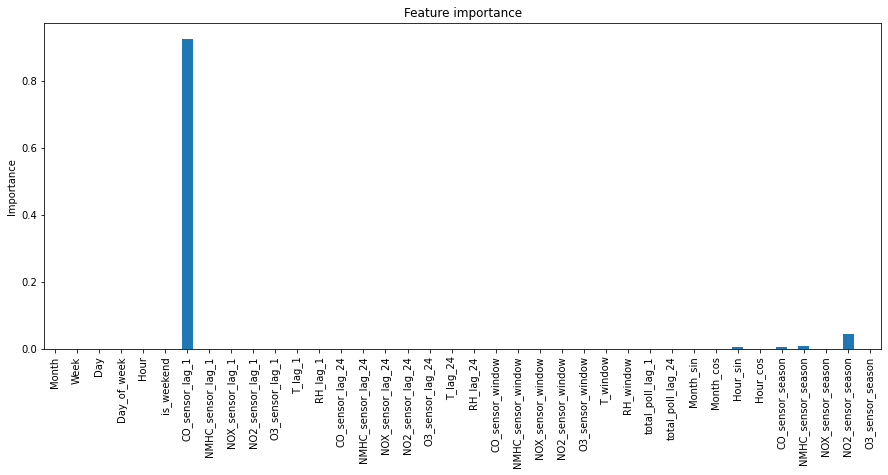

In [69]:
# Let's now plot the feature's importance
# according to the Random Forests

# The importance is stored in the estimator.
tmp = pd.Series(cv_results['estimator']
                [0].named_steps['rf'].feature_importances_)

# Let's add the variable names.
tmp.index = input_variables + ['CO_sensor_season',
                               'NMHC_sensor_season',
                               'NOX_sensor_season',
                               'NO2_sensor_season',
                               'O3_sensor_season']

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title('Feature importance')
plt.ylabel('Importance')

We see that the most important feature is the concentration of CO in the previous hour, as expected. The seasonal components of CO, NO2 and NMHC add a bit of value to the prediction as well. And this is probably why the Random Forests returned better predictions than the naive forecast.

Most of the features we created are not really useful. We could have probably made our lives easier by starting simpler, with just lags from the feature we wanted to predict. But then the demo would be really boring, wouldn't it?

## Linear Regression

Random Forest regression models are not very good at extrapolating values beyond those observed in the data. So let's now train a machine learning pipeline with a Lasso regression for comparison.

In [70]:
pipe_linear = Pipeline([
    
    # create seasonal features
    ('seasonal', SeasonalTransformer(
        season_var='Hour', variables=pollutants)
    ),
    
    # drop original (raw) variables. These are only 
    # needed to capture the seasonality.
    ('drop_vars', DropFeatures(features_to_drop=vars_to_drop)),
    
    # random forests
    ('lasso', Lasso(random_state=0)),    
])

In [71]:
# Let's predict CO concentration

cv_results = cross_validate(
    estimator=pipe_linear,  # our linear pipeline
    X=X_train,              # the training data
    y=X_train['CO_sensor'],  # the target
    cv=tscv,    # the cross validation scheme
    scoring='neg_root_mean_squared_error', # the metric to evaluate
    return_train_score=True, 
    return_estimator=True, # we want a final model to be trained on the entire train set
)

C:\Users\Sole\Documents\Repositories\envs\fets\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5691265.141887822, tolerance: 7517.294876000003
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fets\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9638476.400735982, tolerance: 12489.505299218741
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sole\Documents\Repositories\envs\fets\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15183049.48686408, tolerance: 22129.12713147917
  model = cd_fast.enet_coordinate_descent(


In [72]:
# Mean performance during cross-validation

print('train rmse: ', np.mean(
    cv_results['train_score']), '+-', np.std(cv_results['train_score']))
print('test rmse: ', np.mean(
    cv_results['test_score']), '+-', np.std(cv_results['test_score']))

train rmse:  -84.48607531153091 +- 3.702999363275863
test rmse:  -83.6848631779964 +- 6.733098491190299


In [73]:
# Now let's make predictions for the test set.
preds_linear = cv_results['estimator'][0].predict(X_test)

# Let's find the rmse.
mean_squared_error(X_test['CO_sensor'], preds_linear, squared=False)

100.42845655771072

We can see an uplift with respect to the Naive forecast and also the Random Forests.

Text(0, 0.5, 'Importance')

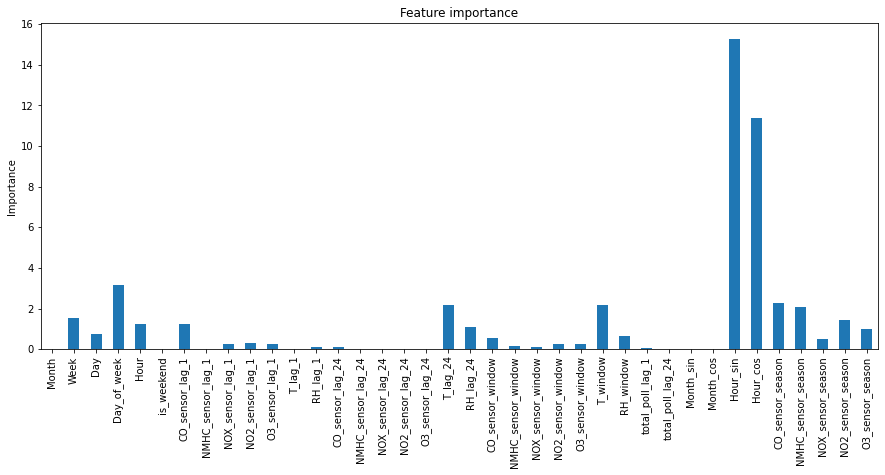

In [74]:
# Let's now plot the feature's importance
# according to the Random Forests

# The importance is stored in the estimator.
tmp = pd.Series(np.abs(
    cv_results['estimator'][0].named_steps['lasso'].coef_)
               )

# Let's add the variable names.
tmp.index = input_variables + ['CO_sensor_season',
                               'NMHC_sensor_season',
                               'NOX_sensor_season',
                               'NO2_sensor_season',
                               'O3_sensor_season']

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title('Feature importance')
plt.ylabel('Importance')

The linear regression model was able to capture more value from the features in the data to forecast. Maybe this is why we see a small uplift respect to Random Forests.

## Plot the 3 models

Let's compare the predictions of the 3 models by plotting the predictions against the truth.

In [75]:
len(X_test), len(preds)

(494, 494)

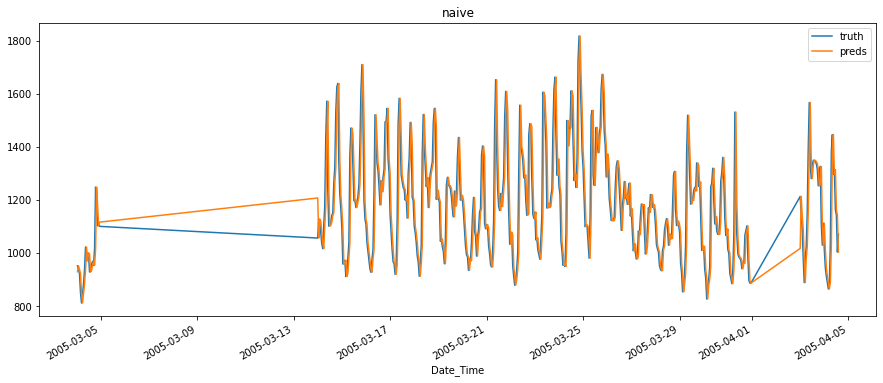

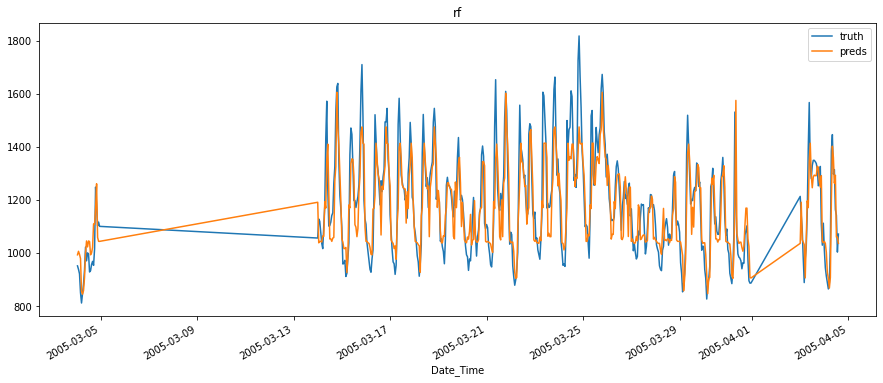

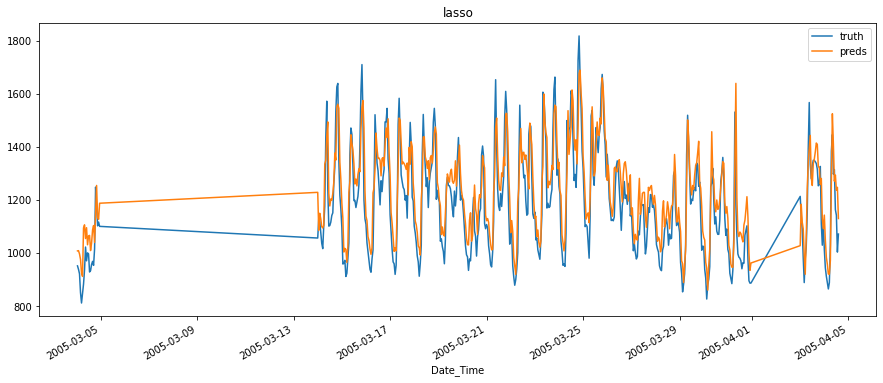

In [76]:
models_dict = {
    'naive': X_test['CO_sensor_lag_1'],
    'rf': preds,
    'lasso': preds_linear,
}

for model in models_dict.keys():

    # predictions
    preds_ = models_dict[model]

    tmp = pd.concat([
        X_test['CO_sensor'].reset_index(drop=True),
        pd.Series(preds_).reset_index(drop=True),
    ], axis=1)

    tmp.columns = ['truth', 'preds']

    tmp.index = X_test.index

    tmp.plot(figsize=(15, 6))

    plt.title(model)

# Video 5: Multi-series predictions

Now, to make it a tiny bit more real, we will train models to forecast the concentration of every pollutant.

In [77]:
# We will clone the pipeline so that we 
# do not retrain te same object every time
from sklearn.base import clone

# clone allows us to create multiple identical pipelines

In [78]:
pollutants

['CO_sensor', 'NMHC_sensor', 'NOX_sensor', 'NO2_sensor', 'O3_sensor']

## Train models with CV

In [79]:
# We store the trained pipelines in a 
# dictionary
models = {}

# For comparison, we will also store
# the predictions from our naive forecast
naive_forecast ={}

for pollutant in pollutants:

    # clone the pipeline
    pipe_int = clone(pipe)

    # train the model with cross-val
    cv_results = cross_validate(
        estimator=pipe_int,
        X=X_train,
        y=X_train[pollutant],
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        return_train_score=True,
        return_estimator=True,
    )

    # store the results
    models[pollutant] = cv_results
    
    # ============
    # Naive forecast
    naive_forecast[pollutant] = naive_cv(X_train, pollutant)
    

## Evaluate models

In [80]:
# Print the model performance for each pollutant

for pollutant in pollutants:

    print(pollutant)
    # Randon Forests
    cv_results = models[pollutant]

    print('RF: train rmse: ', np.mean(
        cv_results['train_score']), '+-', np.std(cv_results['train_score']))
    print('RF: test rmse: ', np.mean(
        cv_results['test_score']), '+-', np.std(cv_results['test_score']))

    # Naive Forecast
    rmse_train, rmse_test = naive_forecast[pollutant]

    print('Naive: train rmse: ', np.mean(rmse_train), '+-', np.std(rmse_train))
    print('Naive: test rmse: ', np.mean(rmse_test), '+-', np.std(rmse_test))
    print()

CO_sensor
RF: train rmse:  -96.5037316396324 +- 3.234781696673297
RF: test rmse:  -96.39220687933657 +- 8.423362793980937
Naive: train rmse:  108.99963315823713 +- 4.948601006879665
Naive: test rmse:  98.2508259523338 +- 6.933898592005048

NMHC_sensor
RF: train rmse:  -117.8398897632776 +- 4.446506099451743
RF: test rmse:  -122.75341049356773 +- 17.797817437492462
Naive: train rmse:  143.9538361528611 +- 3.7804184715003935
Naive: test rmse:  133.74383335274914 +- 8.900383799518735

NOX_sensor
RF: train rmse:  -107.9611880035424 +- 3.0731608551079685
RF: test rmse:  -115.39500498796026 +- 12.700077551052553
Naive: train rmse:  115.00653822545286 +- 2.072074271433866
Naive: test rmse:  113.5106285551066 +- 4.682782829111106

NO2_sensor
RF: train rmse:  -134.28959742341547 +- 2.6955371846509744
RF: test rmse:  -138.32175594573667 +- 13.195622309967426
Naive: train rmse:  160.7233246147259 +- 5.115007989621346
Naive: test rmse:  139.23421220030684 +- 15.689718861723577

O3_sensor
RF: train

## Feature's importance

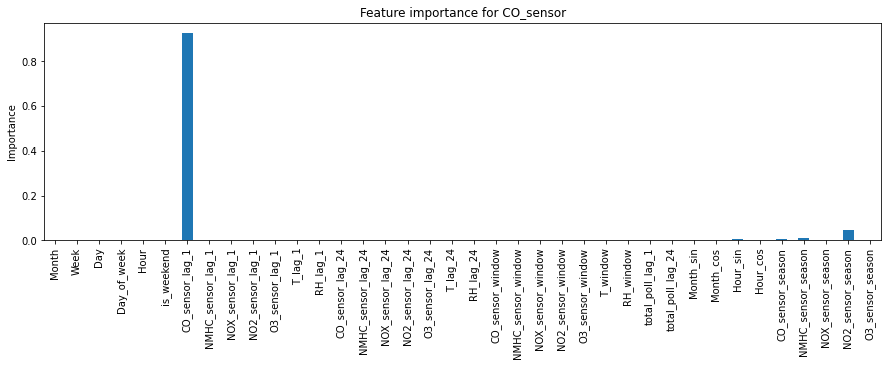

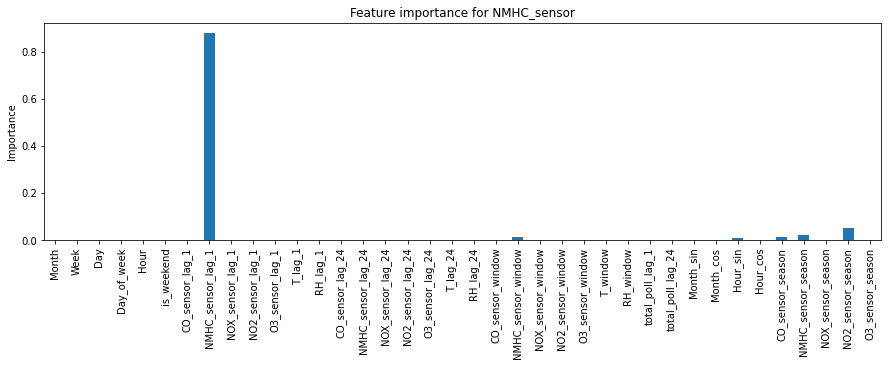

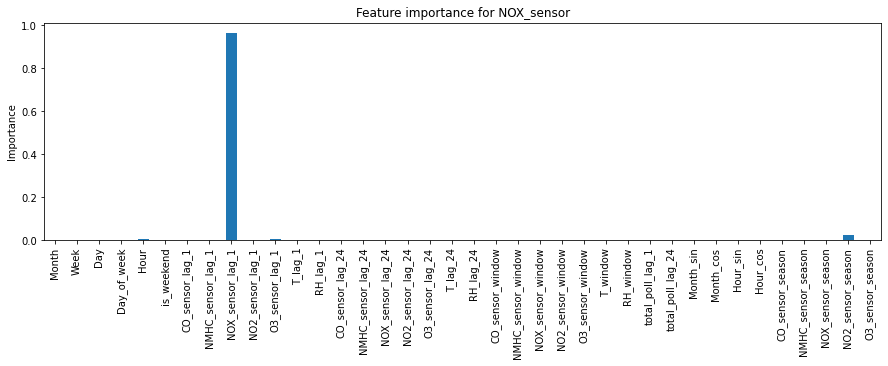

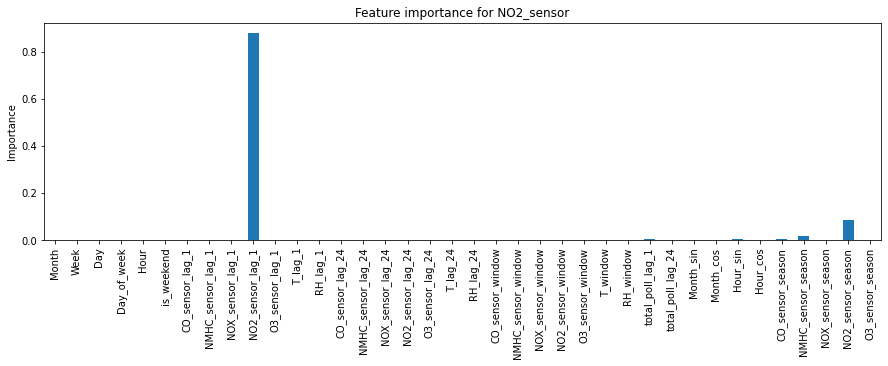

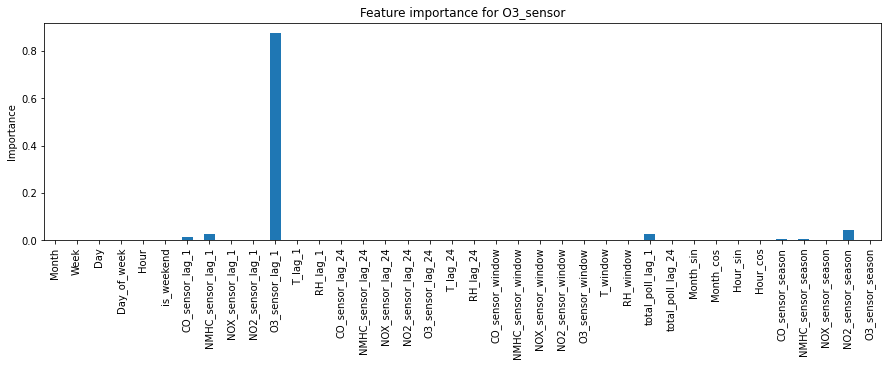

In [81]:
# For every model we plot the feature's importance.

for pollutant in pollutants:
    
    cv_results = models[pollutant]

    tmp = pd.Series(cv_results['estimator']
                    [0].named_steps['rf'].feature_importances_)

    tmp.index = input_variables + ['CO_sensor_season',
     'NMHC_sensor_season',
     'NOX_sensor_season',
     'NO2_sensor_season',
     'O3_sensor_season']

    tmp.plot.bar(figsize=(15,4))
    plt.title('Feature importance for ' + pollutant)
    plt.ylabel('Importance')
    plt.show()

CO_sensor
RMSE: 102.88062933604054


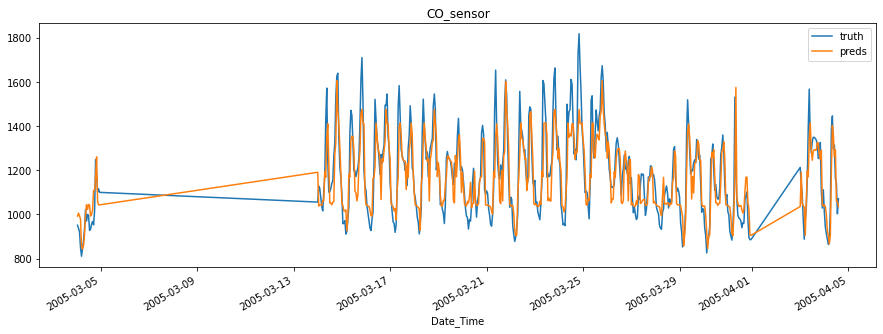

NMHC_sensor
RMSE: 121.1108741114408


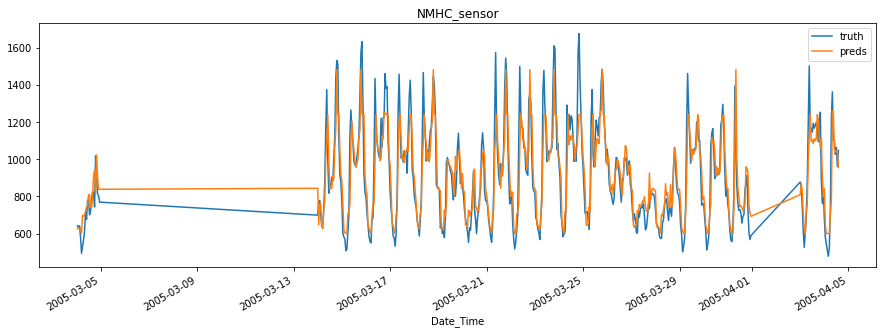

NOX_sensor
RMSE: 91.93402395361085


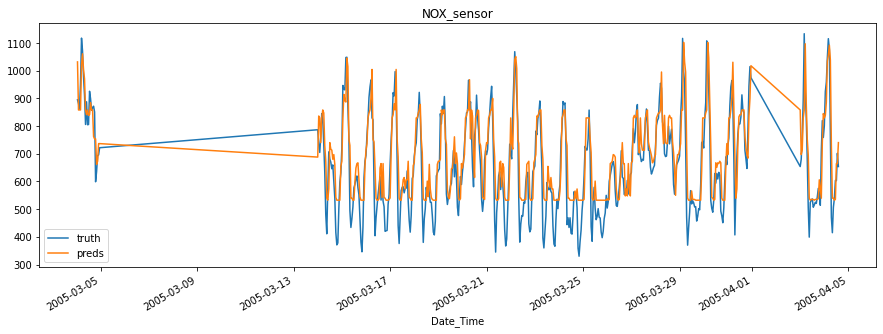

NO2_sensor
RMSE: 151.90799590928864


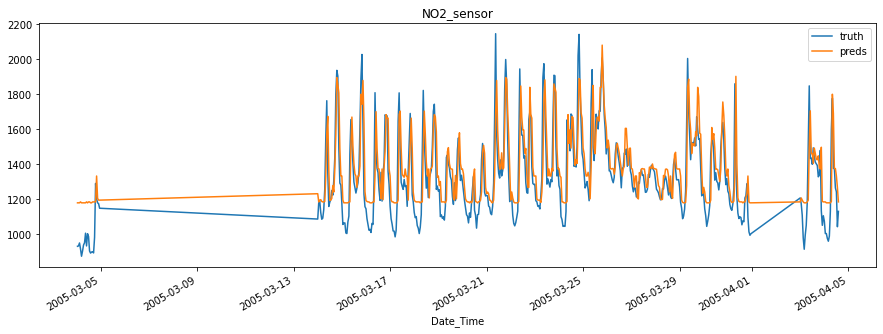

O3_sensor
RMSE: 193.30112291039543


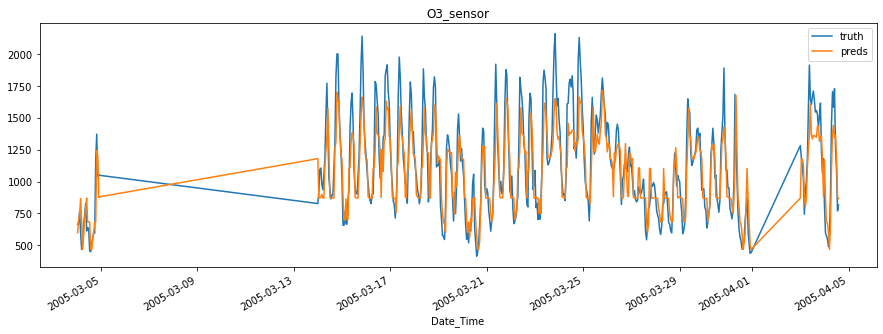

In [82]:
# To finish off, we will test the model on the
# test set

for pollutant in pollutants:
    
    cv_results = models[pollutant]
    
    # make predictions
    preds = cv_results['estimator'][0].predict(X_test)

    # determine rmse
    rmse = mean_squared_error(X_test[pollutant], preds, squared=False)
    
    print(pollutant)
    print('RMSE:', rmse )

    # plot the predictions
    tmp = pd.concat([
        X_test[pollutant].reset_index(drop=True),
        pd.Series(preds),
        ], axis=1)

    tmp.columns = ['truth', 'preds']

    tmp.index = X_test.index

    tmp.plot(figsize=(15,5))
    plt.title(pollutant)
    plt.show()

In general, the models look OK. They tend to be more conservative, not predicting the lowest or highest pollutant concentrations with good accuracy.

This is just a demo to get you started with feature engineering, though.

That is all for this notebook. I hope you enjoyed it!